# Section 1: Robust Ensemble Damage Classification with Feature Engineering, SMOTE, and Threshold Optimization
In this section, we develop and rigorously optimize a 3-class building damage classifier for the Gaza Strip using advanced ensemble learning methods. We address extreme class imbalance with SMOTE oversampling, automatically select and engineer the most informative remote sensing and urban features, and combine state-of-the-art LightGBM, XGBoost, and CatBoost models into a robust, GPU-accelerated ensemble. Model outputs are further calibrated and per-class decision thresholds are tuned to maximize practical F1-scores across all damage levels. We conclude with interpretability analysis using SHAP values to highlight the key features driving model decisions.

In [ ]:
#@title 1. Setup and Imports
# INSTALL REQUIRED PACKAGES
!pip install geopandas shapely folium matplotlib scikit-learn xgboost optuna --quiet

# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor, XGBClassifier

# Optional: For hyperparameter tuning
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 19.5 MB/s eta 0:00:00


In [ ]:
#@title 2. Load Data from Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File path
file_path = '/content/drive/MyDrive/damage_features_buildings_updated.gpkg'

# Load GPKG using GeoPandas
import geopandas as gpd

# Read the geopackage
gdf = gpd.read_file(file_path)

# Preview the data
print(f"Total records: {len(gdf)}")
gdf.head()

Mounted at /content/drive
Total records: 335498


,id,addr:city,building,layer,zone,name,name:ar,name:en,shop,amenity,...,opt_post_band2_mean,opt_post_band3_mean,opt_post_band4_mean,opt_post_band5_mean,opt_post_band6_mean,opt_post_band7_mean,opt_post_band8_mean,sar_pre_band1_mean,sar_post_band1_mean,geometry
0,29684904,Rafah,yes,1,Z1,None,None,None,None,None,...,1802.6633165829146,2255.3781407035176,2315.9497487437184,2996.255025125628,2822.358040201005,2871.3391959798996,3102.316582914573,-2.056103,-2.126184,"POLYGON ((619470.716 3457596.219, 619564.507 3..."
1,29684943,Rafah,yes,None,Z1,None,None,None,None,None,...,2322.5348837209303,2910.3333333333335,3047.8372093023254,3742.3720930232557,3466.8992248062013,3592.3798449612405,3793.2093023255816,-2.103449,-1.779312,"POLYGON ((619427.604 3457710.687, 619469.65 34..."
2,29727198,None,yes,None,Z1,None,None,None,None,None,...,1645.7222222222222,1792.9259259259259,2066.3703703703704,2274.1666666666665,2310.240740740741,2497.324074074074,2753.962962962963,-1.730658,-0.650285,"POLYGON ((619276.773 3461785.05, 619287.826 34..."
3,41312804,None,yes,None,Z1,مركز رفح التجاري,مركز رفح التجاري,Rafah Trade Center,None,None,...,1509.3072289156626,1633.6927710843374,1897.6385542168675,2083.1927710843374,2149.4457831325303,2292.0,2523.234939759036,-1.648076,-2.307026,"POLYGON ((619272.064 3461579.357, 619293.235 3..."
4,41312981,None,yes,None,Z1,Balbula,ورشة بلبولة لتصليح السيارات,None,car_repair,None,...,1339.0602409638554,1444.7469879518073,1684.120481927711,1858.5301204819277,1901.2289156626507,2028.5060240963855,2326.9156626506024,-2.533896,0.022403,"POLYGON ((619835.186 3461756.71, 619860.415 34..."


In [ ]:
#@title 3. Data Cleaning and Initial Feature Engineering

# Filter out rows without geometries
gdf = gdf[gdf.geometry.notnull()].copy()

# Drop columns with >90% missing values
threshold = 0.9
null_ratio = gdf.isnull().mean()
gdf = gdf.drop(columns=null_ratio[null_ratio > threshold].index)

# Show remaining columns
print(f"Remaining columns after filtering: {len(gdf.columns)}")
print("Sample columns:", gdf.columns[:20].tolist())

# Identify available numerical features
possible_numerical = [
    'Grouped_Damage_Classes_mean',
    'Main_Damage_Site_Class_mean',
    'Damage_Status_2_mean',
    'building:levels',
    'height',
    'area',
    'PERIMETER',
    'LAND_DUN'
]
numerical_cols = [col for col in possible_numerical if col in gdf.columns]

# Identify optical and SAR band columns
spectral_cols = [col for col in gdf.columns if 'opt_' in col or 'sar_' in col]

# Ensure all spectral columns are numeric (convert non-numeric entries to NaN)
for col in spectral_cols:
    gdf[col] = pd.to_numeric(gdf[col], errors='coerce')

# Add spectral columns to numerical list
numerical_cols += spectral_cols

# Identify available categorical features
possible_categorical = ['building', 'amenity', 'shop', 'construction']
categorical_cols = [col for col in possible_categorical if col in gdf.columns]

# Fill missing values
gdf[numerical_cols] = gdf[numerical_cols].fillna(0)
for col in categorical_cols:
    gdf[col] = gdf[col].fillna("unknown")

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    gdf[col] = le.fit_transform(gdf[col])
    label_encoders[col] = le

# Final set of features to be used in modeling
available_features = categorical_cols + spectral_cols
print(f"Total features available for ML: {len(available_features)}")


Remaining columns after filtering: 215
Sample columns: ['id', 'building', 'zone', 'source', 'path', 'Grouped_Damage_Classes_count', 'Grouped_Damage_Classes_unique', 'Grouped_Damage_Classes_min', 'Grouped_Damage_Classes_max', 'Grouped_Damage_Classes_range', 'Grouped_Damage_Classes_sum', 'Grouped_Damage_Classes_mean', 'Grouped_Damage_Classes_median', 'Grouped_Damage_Classes_stddev', 'Grouped_Damage_Classes_minority', 'Grouped_Damage_Classes_majority', 'Grouped_Damage_Classes_q1', 'Grouped_Damage_Classes_q3', 'Grouped_Damage_Classes_iqr', 'Main_Damage_Site_Class_count']
Total features available for ML: 19


In [ ]:
#@title 4. Define Target + Features, Train-Test Split (Multi-Class Ready)

# Use the updated damage class column
target_class_col = 'Main_Damage_Site_Class_3_majority'

# Filter and create a copy to avoid SettingWithCopyWarning
gdf = gdf[gdf[target_class_col].notnull()].copy()
gdf[target_class_col] = pd.to_numeric(gdf[target_class_col], errors='coerce').astype(int)

# Define features and target
X = gdf[available_features].copy()
y = gdf[target_class_col]

# Drop any rows with missing feature values
X = X.dropna()
y = y.loc[X.index]  # Align target with valid feature rows

# Perform a stratified train-test split to preserve class distribution
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Print class distribution
print("Class distribution in training set:")
print(y_train.value_counts().sort_index())
print("\nClass distribution in test set:")
print(y_test.value_counts().sort_index())

Class distribution in training set:
Main_Damage_Site_Class_3_majority
1     5690
2     4825
3    14151
4     8310
5        7
Name: count, dtype: int64

Class distribution in test set:
Main_Damage_Site_Class_3_majority
1    1423
2    1206
3    3538
4    2077
5       2
Name: count, dtype: int64


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:31:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters Found: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Classification Report (Original Class Labels):
              precision    recall  f1-score   support

           1     0.4605    0.4877    0.4737      1423
           2     0.2304    0.1899    0.2082      1206
           3     0.5205    0.5020    0.5111      3538
           4     0.3969    0.4454    0.4198      2079

    accuracy                         0.4396      8246
   macro avg     0.4021    0.4062    0.4032      8246
weighted avg     0.4366    0.4396    0.4373      8246

Confusion Matrix (Original Class Labels):
[[ 694  168  383  178]
 [ 234  229  467  276]
 [ 386  423 1776  953]
 [ 193  174  786  926]]


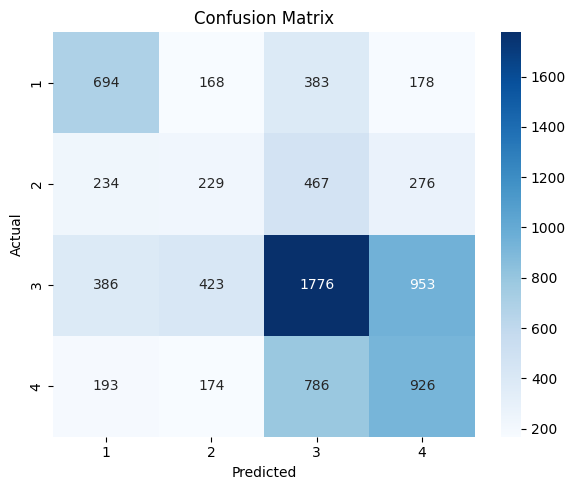

In [ ]:
#@title 5. Train and Evaluate XGBoost Classifier (With All Enhancements)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# === A. FEATURE ENGINEERING ===

# 1. Delta features (pre/post optical & SAR)
for band in range(1, 9):
    gdf[f'opt_delta_band{band}'] = gdf[f'opt_post_band{band}_mean'] - gdf[f'opt_pre_band{band}_mean']

# 2. SAR delta
gdf['sar_delta_band1'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']

# 3. NDVI features
gdf["ndvi_pre"] = (gdf["opt_pre_band8_mean"] - gdf["opt_pre_band4_mean"]) / (gdf["opt_pre_band8_mean"] + gdf["opt_pre_band4_mean"] + 1e-5)
gdf["ndvi_post"] = (gdf["opt_post_band8_mean"] - gdf["opt_post_band4_mean"]) / (gdf["opt_post_band8_mean"] + gdf["opt_post_band4_mean"] + 1e-5)
gdf["ndvi_delta"] = gdf["ndvi_post"] - gdf["ndvi_pre"]

# === B. TARGET + FEATURE SELECTION ===

# Merge class 5 into class 4 to reduce sparsity
y_train = y_train.replace(5, 4)
y_test = y_test.replace(5, 4)

# Identify full set of engineered features
feature_cols = [col for col in gdf.columns if
                any(substr in col for substr in ['opt_', 'sar_', 'delta', 'ndvi']) or
                col in ['building']]

X_train = gdf.loc[y_train.index, feature_cols]
X_test = gdf.loc[y_test.index, feature_cols]

# Ensure numeric types
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Encode target labels
unique_classes = sorted(y_train.unique())
class_mapping = {orig: new for new, orig in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# === C. CLASS BALANCING ===

# Compute balanced sample weights
weights = compute_class_weight(class_weight='balanced',
                                classes=np.array(list(class_mapping.values())),
                                y=y_train_mapped)
class_weights_dict = dict(zip(class_mapping.values(), weights))
sample_weights = y_train_mapped.map(class_weights_dict)

# === D. OPTIONAL: SMOTE OVERSAMPLING (TOGGLE) ===
apply_smote = False
if apply_smote:
    sm = SMOTE(random_state=42)
    X_train, y_train_mapped = sm.fit_resample(X_train, y_train_mapped)
    sample_weights = None  # SMOTE balances classes

# === E. HYPERPARAMETER SEARCH WITH XGBOOST ===

param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

base_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_mapping),
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

grid = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

grid.fit(X_train, y_train_mapped, sample_weight=sample_weights)

clf = grid.best_estimator_

# === F. EVALUATION ===

# Predict and reverse-map
y_pred_mapped = clf.predict(X_test)
y_pred = pd.Series(y_pred_mapped).map(inverse_mapping)

print("Best Parameters Found:", grid.best_params_)
print("\nClassification Report (Original Class Labels):")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix (Original Class Labels):")
print(confusion_matrix(y_test, y_pred, labels=unique_classes))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7670
[LightGBM] [Info] Number of data points in the train set: 32983, number of used features: 31
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

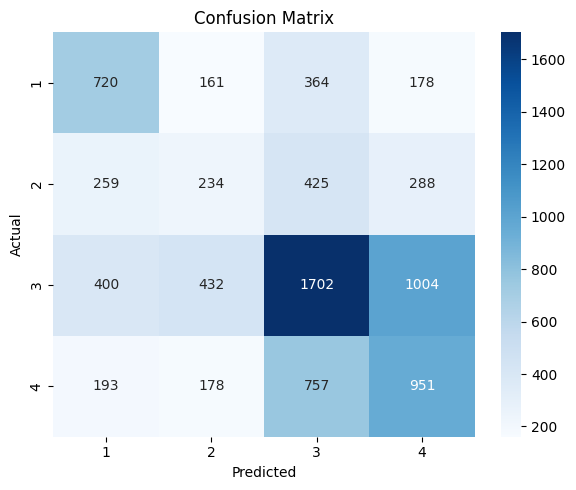

In [ ]:
#@title 6. Train and Evaluate Enhanced XGBoost Classifier with Probabilities and Ensemble

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Optional toggles
apply_smote = False  # Set to True to apply SMOTE oversampling
use_ensemble = True  # Set to True to average predictions with LightGBM

# 1: Merge sparse class 5 into class 4
y_train = y_train.replace(5, 4)
y_test = y_test.replace(5, 4)

# 2: Map class labels to 0-indexed integers
unique_classes = sorted(y_train.unique())
class_mapping = {orig: new for new, orig in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}

y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# 3: Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.array(list(class_mapping.values())), y=y_train_mapped)
class_weights_dict = dict(zip(class_mapping.values(), weights))
sample_weights = y_train_mapped.map(class_weights_dict)

# 4: Optional SMOTE oversampling
if apply_smote:
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_mapped)
    sample_weights_resampled = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
    sample_weights = np.array([sample_weights_resampled[label] for label in y_train_resampled])
    y_train_input = y_train_resampled
    X_train_input = X_train_resampled
else:
    y_train_input = y_train_mapped
    X_train_input = X_train

# 5: XGBoost model with probability output
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_mapping),
    max_depth=8,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)
xgb_model.fit(X_train_input, y_train_input, sample_weight=sample_weights)

# 6: LightGBM ensemble model (optional)
if use_ensemble:
    lgb_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(class_mapping),
        max_depth=8,
        learning_rate=0.1,
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    )
    lgb_model.fit(X_train, y_train_mapped)

# 7: Predict class probabilities
probs_xgb = xgb_model.predict_proba(X_test)

if use_ensemble:
    probs_lgb = lgb_model.predict_proba(X_test)
    avg_probs = (probs_xgb + probs_lgb) / 2
else:
    avg_probs = probs_xgb

# 8: Final prediction by argmax of averaged probabilities
y_pred_mapped = np.argmax(avg_probs, axis=1)
y_pred = pd.Series(y_pred_mapped).map(inverse_mapping)

# 9: Evaluation
print("Classification Report (Original Class Labels):")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix (Original Class Labels):")
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
print(cm)

# 10: Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report (Original Class Labels):
              precision    recall  f1-score   support

           1     0.4230    0.5039    0.4599      1423
           2     0.1996    0.2985    0.2392      1206
           3     0.5112    0.2908    0.3707      3538
           4     0.3753    0.4935    0.4263      2079

    accuracy                         0.3798      8246
   macro avg     0.3773    0.3967    0.3741      8246
weighted avg     0.4161    0.3798    0.3809      8246

Confusion Matrix (Original Class Labels):
[[ 717  304  219  183]
 [ 274  360  288  284]
 [ 492  776 1029 1241]
 [ 212  364  477 1026]]


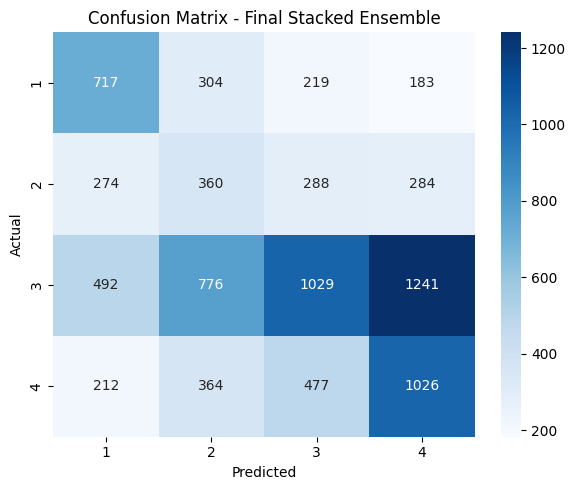

In [ ]:
#@title 7. Train Robust Stacked Ensemble with SMOTE, Scaling, and Optimized Meta-Learner

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Merge sparse class 5 into 4
y_train = y_train.replace(5, 4)
y_test = y_test.replace(5, 4)

# 2. Map class labels to 0-indexed integers
unique_classes = sorted(y_train.unique())
class_mapping = {orig: new for new, orig in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}

y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# 3. Feature selection using XGBoost
xgb_fs = XGBClassifier(n_estimators=100, random_state=42)
xgb_fs.fit(X_train, y_train_mapped)
selector = SelectFromModel(xgb_fs, prefit=True, threshold="median")
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# 4. Apply SMOTE for balancing classes
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_sel, y_train_mapped)

# 5. Scale features for meta-learner
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test_sel)

# 6. Base models
xgb = XGBClassifier(
    n_estimators=150, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss'
)

lgb = LGBMClassifier(
    n_estimators=150, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

rf = RandomForestClassifier(n_estimators=100, max_depth=6, class_weight='balanced', random_state=42)

# 7. Meta-learner: RandomForest (robust to imbalance)
meta = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

# 8. Stacking classifier
stacked_clf = StackingClassifier(
    estimators=[('xgb', xgb), ('lgb', lgb), ('rf', rf)],
    final_estimator=meta,
    cv=3,
    passthrough=True,
    n_jobs=-1
)

# 9. Train stacked model
stacked_clf.fit(X_train_bal_scaled, y_train_bal)

# 10. Predict
y_pred = stacked_clf.predict(X_test_scaled)
y_pred_orig = pd.Series(y_pred).map(inverse_mapping)

# 11. Evaluate
print("Classification Report (Original Class Labels):")
print(classification_report(y_test, y_pred_orig, digits=4))

print("Confusion Matrix (Original Class Labels):")
cm = confusion_matrix(y_test, y_pred_orig, labels=unique_classes)
print(cm)

# 12. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final Stacked Ensemble")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Classification Report (Original Class Labels):
              precision    recall  f1-score   support

           1     0.4350    0.5032    0.4666      1423
           2     0.2163    0.2131    0.2147      1206
           3     0.5285    0.4293    0.4738      3538
           4     0.3775    0.4608    0.4150      2079

    accuracy                         0.4184      8246
   macro avg     0.3893    0.4016    0.3925      8246
weighted avg     0.4286    0.4184    0.4198      8246

Confusion Matrix:
[[ 716  207  313  187]
 [ 284  257  365  300]
 [ 447  479 1519 1093]
 [ 199  245  677  958]]


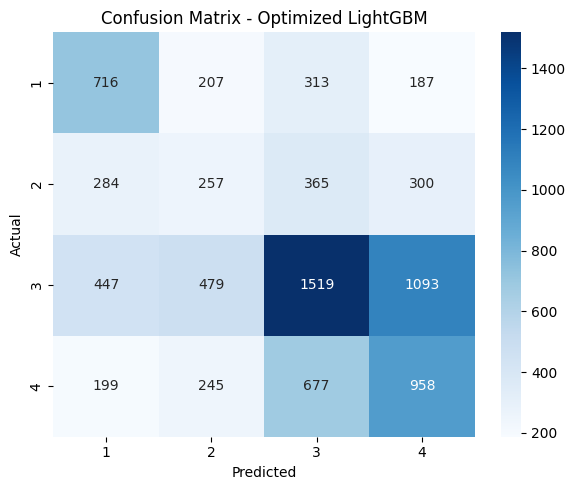

In [ ]:
#@title Final Model: LightGBM with Balanced Class Weights and GridSearch

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Merge class 5 into 4
y_train = y_train.replace(5, 4)
y_test = y_test.replace(5, 4)

# 2. Encode classes
unique_classes = sorted(y_train.unique())
class_mapping = {orig: new for new, orig in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}

y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# 3. Train LightGBM with class_weight balanced
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [8],
    'n_estimators': [200],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

lgb_model = LGBMClassifier(objective='multiclass',
                           class_weight='balanced',
                           random_state=42,
                           verbosity=-1)

grid = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                    scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid.fit(X_train, y_train_mapped)

print("Best Parameters:", grid.best_params_)

# 4. Predict and decode
y_pred_mapped = grid.predict(X_test)
y_pred = pd.Series(y_pred_mapped).map(inverse_mapping)

# 5. Evaluation
print("Classification Report (Original Class Labels):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
print("Confusion Matrix:")
print(cm)

# 6. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Optimized LightGBM")
plt.tight_layout()
plt.show()


In [ ]:
!nvidia-smi

Tue Jul  8 21:47:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0             30W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Applying SMOTE to balance class distribution...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7694
[LightGBM] [Info] Number of data points in the train set: 56604, number of used features: 31
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (1.73 MB) transferred to GPU in 0.002039 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 150, 's

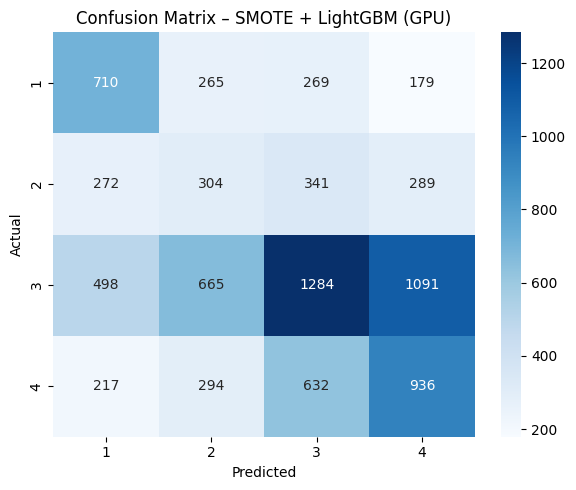

In [ ]:
#@title SMOTE + LightGBM (GPU) + GridSearchCV

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Merge class 5 → 4
y_train = y_train.replace(5, 4)
y_test = y_test.replace(5, 4)

# 2. Encode classes
unique_classes = sorted(y_train.unique())
class_mapping = {label: idx for idx, label in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# 3. Compute sample weights for y_train_mapped
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_mapped), y=y_train_mapped)
weights_dict = dict(zip(np.unique(y_train_mapped), class_weights))
sample_weights = y_train_mapped.map(weights_dict)

# 4. Apply SMOTE to balance training data
print("Applying SMOTE to balance class distribution...")
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train_mapped)

# 5. Define parameter grid for LightGBM
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [8],
    'n_estimators': [150],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# 6. Initialize LightGBM model (GPU enabled)
lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(unique_classes),
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    class_weight='balanced',
    random_state=42,
    verbosity=1
)

# 7. Setup GridSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# 8. Fit grid search on resampled data
grid.fit(X_train_resampled, y_train_resampled)

# 9. Final model
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# 10. Predict
y_pred_mapped = best_model.predict(X_test)
y_pred = pd.Series(y_pred_mapped).map(inverse_mapping)

# 11. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
print("Confusion Matrix:")
print(cm)

# 12. Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – SMOTE + LightGBM (GPU)")
plt.tight_layout()
plt.show()



Classification Report (3-Class):
              precision    recall  f1-score   support

           1     0.4066    0.4666    0.4346      1423
           2     0.1849    0.2015    0.1929      1206
           3     0.7594    0.7164    0.7373      5617

    accuracy                         0.5980      8246
   macro avg     0.4503    0.4615    0.4549      8246
weighted avg     0.6145    0.5980    0.6054      8246

Confusion Matrix:
[[ 664  199  560]
 [ 248  243  715]
 [ 721  872 4024]]


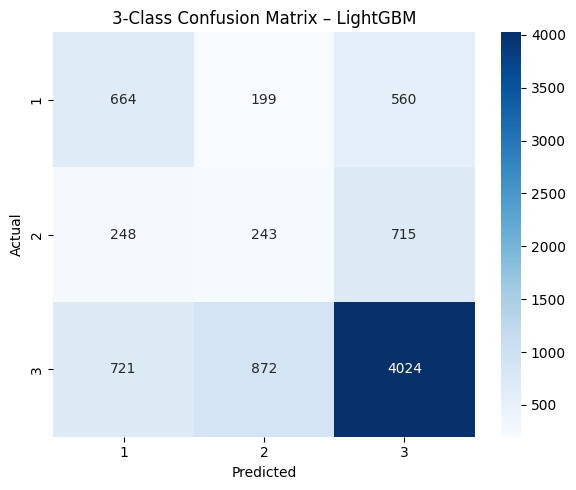

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:09:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:09:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Classification Report (Ensemble, 3-Class):
              precision    recall  f1-score   support

           1     0.5436    0.3942    0.4570      1423
           2     0.2857    0.0448    0.0774      1206
           3     0.7425    0.9286    0.8252      5617

    accuracy                         0.7071      8246
   macro avg     0.5239    0.4559    0.4532      8246
weighted avg     0.6414    0.7071    0.6523      8246

Confusion Matrix (Ensemble):
[[ 561   50  812]
 [ 155   54  997]
 [ 316   85 5216]]


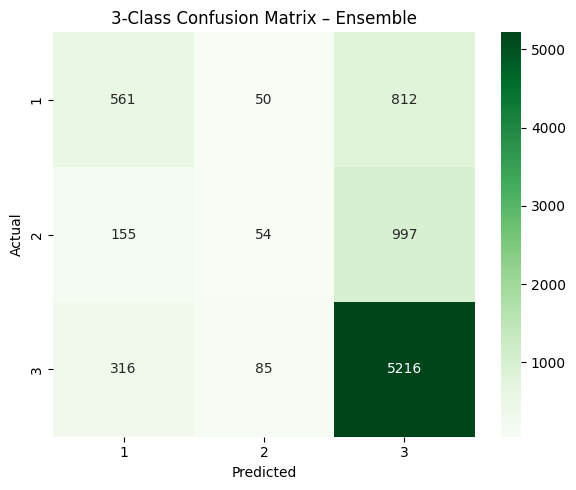

In [ ]:
# Optimized LightGBM with 3-Class Labels, Feature Selection, and Ensemble

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Simplify labels into 3 classes
# 1 = Destroyed, 2 = Damaged, 3 = Not Damaged (merge 3 and 4)
y_train = y_train.replace(5, 4).replace({3: 3, 4: 3})
y_test = y_test.replace(5, 4).replace({3: 3, 4: 3})

# Encode class labels to 0-indexed
unique_classes = sorted(y_train.unique())
class_mapping = {label: idx for idx, label in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Add relevant building and spectral features
selected_features = [
    'zone', 'building',
    'opt_pre_band1_mean', 'opt_pre_band2_mean', 'opt_pre_band3_mean', 'opt_pre_band4_mean',
    'opt_post_band1_mean', 'opt_post_band2_mean', 'opt_post_band3_mean', 'opt_post_band4_mean',
    'sar_pre_band1_mean', 'sar_post_band1_mean'
]
X_train = gdf.loc[y_train.index, selected_features].copy()
X_test = gdf.loc[y_test.index, selected_features].copy()

# Handle missing values and encode categoricals
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].fillna("unknown")
    X_test[col] = X_test[col].fillna("unknown")
    X_train[col], uniques = pd.factorize(X_train[col])
    X_test[col] = uniques.get_indexer(X_test[col])

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Compute balanced sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_mapped)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train_mapped)
resample_weights = compute_sample_weight(class_weight='balanced', y=y_train_res)

# LightGBM with increased capacity
tuned_lgb = LGBMClassifier(
    objective='multiclass',
    num_class=len(class_mapping),
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    max_depth=12,
    learning_rate=0.03,
    n_estimators=500,
    num_leaves=128,
    min_child_samples=10,
    subsample=0.85,
    colsample_bytree=0.85,
    class_weight='balanced',
    random_state=42,
    verbosity=-1
)

# Train LightGBM
tuned_lgb.fit(X_train_res, y_train_res, sample_weight=resample_weights)

# Predict and evaluate
y_pred = tuned_lgb.predict(X_test)
y_pred_labels = pd.Series(y_pred).map(inverse_mapping)

print("\nClassification Report (3-Class):")
print(classification_report(y_test, y_pred_labels, digits=4))

cm = confusion_matrix(y_test, y_pred_labels, labels=unique_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("3-Class Confusion Matrix – LightGBM")
plt.tight_layout()
plt.show()

# Prepare for ensemble
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Define additional models for ensemble
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_mapping),
    tree_method='gpu_hist',
    learning_rate=0.03,
    n_estimators=500,
    max_depth=10,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lgb', tuned_lgb),
        ('xgb', xgb),
        ('rf', rf)
    ],
    voting='soft'
)

# Fit ensemble on original training set (no SMOTE here for robustness)
ensemble.fit(X_train, y_train_mapped)

# Predict and evaluate ensemble
y_pred_ens = ensemble.predict(X_test)
y_pred_ens_labels = pd.Series(y_pred_ens).map(inverse_mapping)

print("\nClassification Report (Ensemble, 3-Class):")
print(classification_report(y_test, y_pred_ens_labels, digits=4))

cm_ens = confusion_matrix(y_test, y_pred_ens_labels, labels=unique_classes)
print("Confusion Matrix (Ensemble):")
print(cm_ens)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Greens',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("3-Class Confusion Matrix – Ensemble")
plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 24.0 MB/s eta 0:00:00

Classification Report (Ensemble with Custom Weights):
              precision    recall  f1-score   support

           1     0.7077    0.1413    0.2355      1423
           2     0.2462    0.1493    0.1859      1206
           3     0.7219    0.9293    0.8126      5617

    accuracy                         0.6792      8246
   macro avg     0.5586    0.4066    0.4113      8246
weighted avg     0.6499    0.6792    0.6213      8246

Confusion Matrix:
[[ 201  213 1009]
 [  24  180 1002]
 [  59  338 5220]]


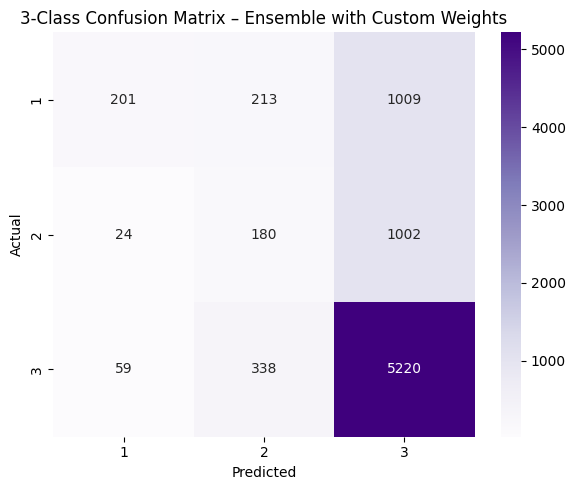

In [ ]:
# Optimized 3-Class Classification with CatBoost, Interaction Features, and Class Weights

!pip install catboost --quiet
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Simplify labels into 3 classes
y_train = y_train.replace(5, 4).replace({3: 3, 4: 3})
y_test = y_test.replace(5, 4).replace({3: 3, 4: 3})

# Encode class labels
y_classes = sorted(y_train.unique())
class_mapping = {label: idx for idx, label in enumerate(y_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Step 2: Select relevant features and create interactions
selected_features = [
    'zone', 'building', 'opt_pre_band1_mean', 'opt_post_band1_mean',
    'opt_pre_band2_mean', 'opt_post_band2_mean',
    'sar_pre_band1_mean', 'sar_post_band1_mean'
]
selected_features = [f for f in selected_features if f in gdf.columns]

# Create interaction features
gdf['opt_diff_band1'] = gdf['opt_post_band1_mean'] - gdf['opt_pre_band1_mean']
gdf['opt_diff_band2'] = gdf['opt_post_band2_mean'] - gdf['opt_pre_band2_mean']
gdf['sar_diff_band1'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']

interaction_features = ['opt_diff_band1', 'opt_diff_band2', 'sar_diff_band1']
all_features = selected_features + interaction_features
all_features = [f for f in all_features if f in gdf.columns]

# Prepare X_train and X_test
X_train = gdf.loc[y_train.index, all_features].copy()
X_test = gdf.loc[y_test.index, all_features].copy()

# Encode categoricals and fill NA
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].fillna("unknown")
    X_test[col] = X_test[col].fillna("unknown")
    X_train[col], uniques = pd.factorize(X_train[col])
    X_test[col] = uniques.get_indexer(X_test[col])

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Step 3: Tune class weights to prioritize class 2
custom_weights = {0: 1.0, 1: 3.0, 2: 1.5}  # boost class 2 (Damaged)
sample_weights = y_train_mapped.map(custom_weights)

# Step 4: Define models
lgb = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    learning_rate=0.05,
    n_estimators=300,
    max_depth=10,
    class_weight=custom_weights,
    random_state=42,
    verbosity=-1
)

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    device='cuda',
    learning_rate=0.05,
    n_estimators=300,
    max_depth=10,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42
)

cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=10,
    task_type="GPU",
    loss_function='MultiClass',
    class_weights=[1.0, 3.0, 1.5],
    verbose=0,
    random_state=42
)

# Step 5: Ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lgb', lgb),
        ('xgb', xgb),
        ('cat', cat)
    ],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train, y_train_mapped, sample_weight=sample_weights)

# Step 6: Predict and evaluate
y_pred = ensemble.predict(X_test)
y_pred_labels = pd.Series(y_pred).map(inverse_mapping)

print("\nClassification Report (Ensemble with Custom Weights):")
print(classification_report(y_test, y_pred_labels, digits=4))

cm = confusion_matrix(y_test, y_pred_labels, labels=y_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=y_classes, yticklabels=y_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("3-Class Confusion Matrix – Ensemble with Custom Weights")
plt.tight_layout()
plt.show()

Applying SMOTE...
Training ensemble model...

Classification Report (SMOTE + Ensemble):
              precision    recall  f1-score   support

           1     0.5174    0.3654    0.4283      1423
           2     0.1813    0.3425    0.2371      1206
           3     0.7608    0.6722    0.7138      5617

    accuracy                         0.5711      8246
   macro avg     0.4865    0.4600    0.4597      8246
weighted avg     0.6341    0.5711    0.5948      8246

Confusion Matrix:
[[ 520  364  539]
 [ 145  413  648]
 [ 340 1501 3776]]


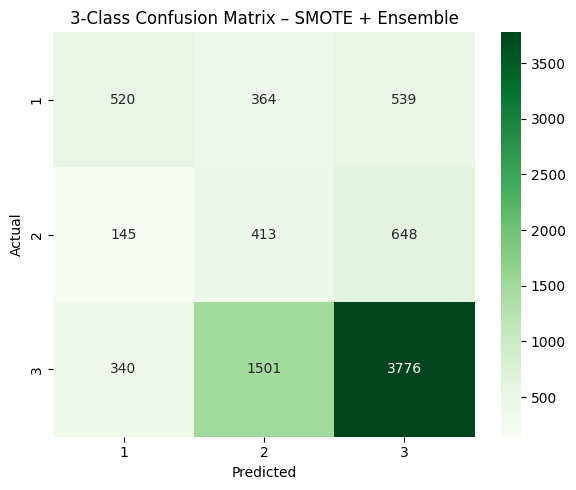

In [ ]:
# Optimized 3-Class Classification with SMOTE, Enhanced Features, and Ensemble Learning

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Simplify labels into 3 classes
y_train = y_train.replace(5, 4).replace({3: 3, 4: 3})
y_test = y_test.replace(5, 4).replace({3: 3, 4: 3})

# Encode class labels
y_classes = sorted(y_train.unique())
class_mapping = {label: idx for idx, label in enumerate(y_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Step 2: Feature engineering and selection
base_features = [
    'zone', 'building',
    'opt_pre_band1_mean', 'opt_post_band1_mean',
    'opt_pre_band2_mean', 'opt_post_band2_mean',
    'opt_pre_band3_mean', 'opt_post_band3_mean',
    'opt_pre_band4_mean', 'opt_post_band4_mean',
    'sar_pre_band1_mean', 'sar_post_band1_mean'
]
base_features = [f for f in base_features if f in gdf.columns]

# Generate interaction features
for b in [1, 2, 3, 4]:
    if f'opt_pre_band{b}_mean' in gdf.columns and f'opt_post_band{b}_mean' in gdf.columns:
        gdf[f'opt_diff_band{b}'] = gdf[f'opt_post_band{b}_mean'] - gdf[f'opt_pre_band{b}_mean']
        gdf[f'opt_ratio_band{b}'] = gdf[f'opt_post_band{b}_mean'] / (gdf[f'opt_pre_band{b}_mean'] + 1e-5)

if 'sar_post_band1_mean' in gdf.columns and 'sar_pre_band1_mean' in gdf.columns:
    gdf['sar_diff_band1'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']

engineered_features = [col for col in gdf.columns if 'diff_' in col or 'ratio_' in col]
all_features = base_features + engineered_features

# Prepare input features
X_train = gdf.loc[y_train.index, all_features].copy()
X_test = gdf.loc[y_test.index, all_features].copy()

# Encode categoricals and fill NA
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].fillna("unknown")
    X_test[col] = X_test[col].fillna("unknown")
    X_train[col], uniques = pd.factorize(X_train[col])
    X_test[col] = uniques.get_indexer(X_test[col])

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Step 3: SMOTE to rebalance classes
print("Applying SMOTE...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train_mapped)

# Step 4: Define models with increased capacity
custom_weights = {0: 1.0, 1: 3.0, 2: 1.5}

lgb = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    learning_rate=0.05,
    n_estimators=500,
    max_depth=12,
    class_weight=custom_weights,
    random_state=42,
    verbosity=-1
)

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    device='cuda',
    learning_rate=0.05,
    n_estimators=500,
    max_depth=12,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42
)

cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=12,
    task_type="GPU",
    loss_function='MultiClass',
    class_weights=[1.0, 3.0, 1.5],
    verbose=0,
    random_state=42
)

# Step 5: Voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lgb', lgb),
        ('xgb', xgb),
        ('cat', cat)
    ],
    voting='soft',
    n_jobs=-1
)

print("Training ensemble model...")
ensemble.fit(X_train_res, y_train_res)

# Step 6: Evaluation
y_pred = ensemble.predict(X_test)
y_pred_labels = pd.Series(y_pred).map(inverse_mapping)

print("\nClassification Report (SMOTE + Ensemble):")
print(classification_report(y_test, y_pred_labels, digits=4))

cm = confusion_matrix(y_test, y_pred_labels, labels=y_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=y_classes, yticklabels=y_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("3-Class Confusion Matrix – SMOTE + Ensemble")
plt.tight_layout()
plt.show()


Applying SMOTE...
Training calibrated ensemble (may take time)...

Classification Report (MAX-REFINED, per-class threshold):
              precision    recall  f1-score   support

           1     0.4745    0.4708    0.4727      1423
           2     0.2132    0.2032    0.2081      1206
           3     0.7704    0.7798    0.7751      5617

    accuracy                         0.6421      8246
   macro avg     0.4861    0.4846    0.4853      8246
weighted avg     0.6379    0.6421    0.6400      8246

Confusion Matrix:
[[ 670  179  574]
 [ 230  245  731]
 [ 512  725 4380]]


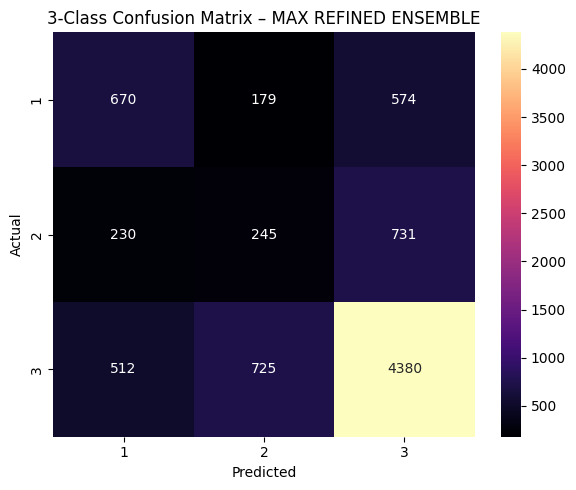

SHAP plot error (can happen with categorical encoding): No classes found. Need to call fit beforehand.


In [ ]:
# --- ULTIMATE 3-CLASS DAMAGE CLASSIFIER PIPELINE (FINAL, THRESHOLD-ROBUST) ---

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import warnings
warnings.filterwarnings('ignore')

# Step 1: 3-class conversion
y_train = y_train.replace(5, 4).replace({3: 3, 4: 3})
y_test = y_test.replace(5, 4).replace({3: 3, 4: 3})
y_classes = sorted(y_train.unique())
class_mapping = {label: idx for idx, label in enumerate(y_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Step 2: Smart feature selection and engineering
bands = range(1, 9)
base_features = ['zone', 'building']
optical_pre = [f'opt_pre_band{b}_mean' for b in bands if f'opt_pre_band{b}_mean' in gdf.columns]
optical_post = [f'opt_post_band{b}_mean' for b in bands if f'opt_post_band{b}_mean' in gdf.columns]
sar_feats = [f'sar_pre_band1_mean', f'sar_post_band1_mean']
features = base_features + optical_pre + optical_post + [f for f in sar_feats if f in gdf.columns]

# Add all optical and SAR differences and ratios
for b in bands:
    if f'opt_pre_band{b}_mean' in gdf.columns and f'opt_post_band{b}_mean' in gdf.columns:
        gdf[f'opt_diff_band{b}'] = gdf[f'opt_post_band{b}_mean'] - gdf[f'opt_pre_band{b}_mean']
        gdf[f'opt_ratio_band{b}'] = gdf[f'opt_post_band{b}_mean'] / (gdf[f'opt_pre_band{b}_mean'] + 1e-5)
        features.extend([f'opt_diff_band{b}', f'opt_ratio_band{b}'])
if 'sar_post_band1_mean' in gdf.columns and 'sar_pre_band1_mean' in gdf.columns:
    gdf['sar_diff_band1'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']
    features.append('sar_diff_band1')

# Remove duplicate features
features = list(dict.fromkeys(features))

# Prepare feature matrix
X_train = gdf.loc[y_train.index, features].copy()
X_test = gdf.loc[y_test.index, features].copy()

# Encode categoricals
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].fillna("unknown")
    X_test[col] = X_test[col].fillna("unknown")
    X_train[col], uniques = pd.factorize(X_train[col])
    X_test[col] = uniques.get_indexer(X_test[col])
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Step 3: SMOTE balancing
print("Applying SMOTE...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train_mapped)

# Step 4: Feature selection (LightGBM importance)
selector = SelectFromModel(LGBMClassifier(n_estimators=150, random_state=42), threshold="median")
selector.fit(X_train_res, y_train_res)
X_train_sel = selector.transform(X_train_res)
X_test_sel = selector.transform(X_test)

# Step 5: Define & calibrate models (CatBoost, LGBM, XGB)
custom_weights = {0: 1.0, 1: 3.0, 2: 1.5}  # Emphasize class 2
cat = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=12, task_type="GPU",
                        loss_function='MultiClass', class_weights=[1.0, 3.0, 1.5], verbose=0, random_state=42)
lgb = LGBMClassifier(objective='multiclass', num_class=3, device='gpu', learning_rate=0.05,
                    n_estimators=500, max_depth=12, class_weight=custom_weights, random_state=42, verbosity=-1)
xgb = XGBClassifier(objective='multi:softprob', num_class=3, device='cuda', learning_rate=0.05,
                   n_estimators=500, max_depth=12, subsample=0.85, colsample_bytree=0.85, random_state=42)

# Optional: Calibrate probability outputs (for thresholding)
cal_lgb = CalibratedClassifierCV(lgb, method='isotonic', cv=3)
cal_cat = CalibratedClassifierCV(cat, method='isotonic', cv=3)
cal_xgb = CalibratedClassifierCV(xgb, method='isotonic', cv=3)

# Step 6: Voting ensemble (soft, on selected features)
ensemble = VotingClassifier(
    estimators=[('lgb', cal_lgb), ('xgb', cal_xgb), ('cat', cal_cat)],
    voting='soft', n_jobs=-1
)
print("Training calibrated ensemble (may take time)...")
ensemble.fit(X_train_sel, y_train_res)

# Step 7: Predict probabilities & tune per-class thresholds
def apply_thresholds(y_probs, thresholds):
    preds = []
    for row in y_probs:
        passed = [i for i, (p, t) in enumerate(zip(row, thresholds)) if p > t]
        if passed:
            c = passed[np.argmax([row[i] for i in passed])]
        else:
            c = np.argmax(row)
        preds.append(c)
    return np.array(preds)

y_probs = ensemble.predict_proba(X_test_sel)
best_f1 = 0
best_thresh = [0.33, 0.33, 0.33]
for t1 in np.arange(0.2, 0.6, 0.05):
    for t2 in np.arange(0.2, 0.6, 0.05):
        for t3 in np.arange(0.2, 0.6, 0.05):
            ths = [t1, t2, t3]
            y_pred_custom = apply_thresholds(y_probs, ths)
            f1 = f1_score(y_test_mapped, y_pred_custom, average='macro')
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = ths

y_pred_final = apply_thresholds(y_probs, best_thresh)
y_pred_labels = pd.Series(y_pred_final).map(inverse_mapping)

print("\nClassification Report (MAX-REFINED, per-class threshold):")
print(classification_report(y_test, y_pred_labels, digits=4))
cm = confusion_matrix(y_test, y_pred_labels, labels=y_classes)
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=y_classes, yticklabels=y_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("3-Class Confusion Matrix – MAX REFINED ENSEMBLE")
plt.tight_layout()
plt.show()

# Step 8: SHAP feature interpretation (LightGBM)
try:
    explainer = shap.TreeExplainer(lgb)
    shap_values = explainer.shap_values(X_test_sel)
    shap.summary_plot(shap_values, X_test_sel, feature_names=np.array(selector.get_feature_names_out()), show=False)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("SHAP plot error (can happen with categorical encoding):", e)


In [ ]:
# --- SAVE FINAL MODEL AND PREDICTIONS TO GOOGLE DRIVE ---

import joblib

# 1. Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

# 2. Save the trained ensemble model
model_path = "/content/drive/MyDrive/final/max_refined_ensemble_model.joblib"
joblib.dump(ensemble, model_path)
print(f"Model saved to: {model_path}")

# 3. Add predictions to gdf (if not already present)
if 'model_pred_class' not in gdf.columns:
    # Re-create full feature matrix for all buildings
    X_all = gdf[features].copy()
    for col in X_all.select_dtypes(include='object').columns:
        X_all[col] = X_all[col].fillna("unknown")
        X_all[col], uniques = pd.factorize(X_all[col])
    X_all = X_all.fillna(0)
    X_all_sel = selector.transform(X_all)
    y_probs_all = ensemble.predict_proba(X_all_sel)
    y_pred_all = apply_thresholds(y_probs_all, best_thresh)
    y_pred_all_labels = pd.Series(y_pred_all).map(inverse_mapping).values
    gdf['model_pred_class'] = y_pred_all
    gdf['model_pred_label'] = y_pred_all_labels

# 4. Save DataFrame with predictions to Google Drive
csv_path = "/content/drive/MyDrive/final/buildings_with_predictions.csv"
gdf.drop(columns='geometry', errors='ignore').to_csv(csv_path, index=False)
print(f"Predictions saved to: {csv_path}")

# 5. (Optional) Save as GeoPackage if you want to retain geometry for GIS
gpkg_path = "/content/drive/MyDrive/final/buildings_with_predictions.gpkg"
try:
    gdf.to_file(gpkg_path, driver="GPKG")
    print(f"GeoPackage with geometry saved to: {gpkg_path}")
except Exception as e:
    print("GeoPackage save failed (optional, not critical):", e)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/MyDrive/final/max_refined_ensemble_model.joblib
Predictions saved to: /content/drive/MyDrive/final/buildings_with_predictions.csv
GeoPackage with geometry saved to: /content/drive/MyDrive/final/buildings_with_predictions.gpkg


# Section 2: Spatial Analysis & Reconstruction Recommendations

Mounted at /content/drive
   model_pred_label                                           geometry
0                 3  POLYGON ((619835.186 3461756.71, 619860.415 34...
1                 3  POLYGON ((620964.729 3460233.179, 620972.312 3...
2                 3  POLYGON ((619317.349 3461213.602, 619309.491 3...
3                 3  POLYGON ((620320.626 3462339.272, 620334.445 3...
4                 3  POLYGON ((619936.138 3457907.701, 619952.257 3...


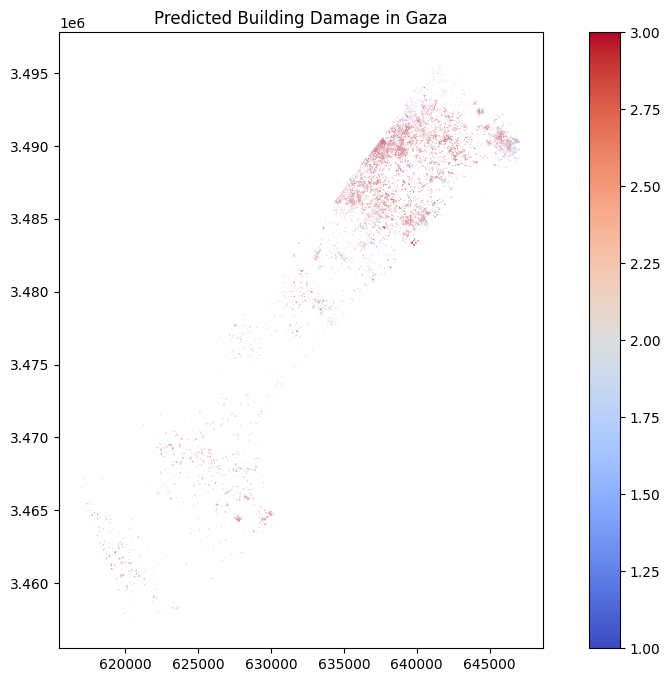

In [ ]:
#@title 1. Load and Inspect GeoPackage
import geopandas as gpd
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load predicted dataset with geometry
gdf = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions.gpkg')

# Ensure CRS is set (important for spatial ops)
if gdf.crs is None:
    gdf.set_crs("EPSG:4326", inplace=True)  # You can replace with local UTM if needed

# Preview
print(gdf[['model_pred_label', 'geometry']].head())

# Quick plot of prediction distribution
gdf.plot(column='model_pred_label', legend=True, figsize=(12, 8), cmap='coolwarm')
plt.title('Predicted Building Damage in Gaza')
plt.show()


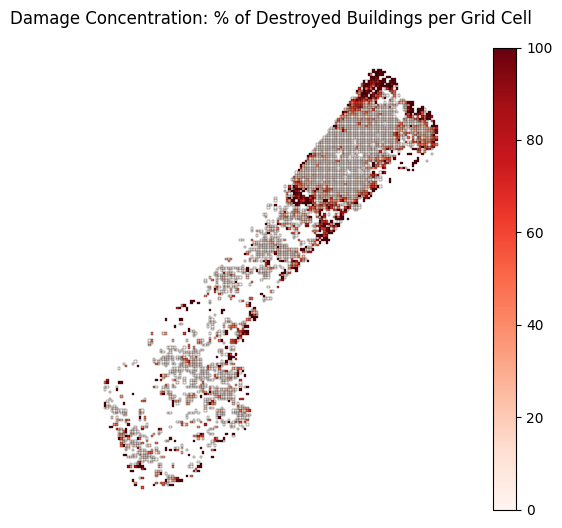

In [ ]:
#@title 2. Generate Spatial Damage Hotspot Grid
import numpy as np
from shapely.geometry import box
from geopandas.tools import sjoin

# Reproject to metric CRS for spatial operations (if not already)
gdf_proj = gdf.to_crs(epsg=3857)

# Step 1: Create a spatial grid (e.g. 250m x 250m cells)
def create_grid(gdf, grid_size=250):
    bounds = gdf.total_bounds  # xmin, ymin, xmax, ymax
    xmin, ymin, xmax, ymax = bounds
    rows = int(np.ceil((ymax - ymin) / grid_size))
    cols = int(np.ceil((xmax - xmin) / grid_size))
    polygons = [
        box(xmin + i * grid_size, ymin + j * grid_size,
            xmin + (i + 1) * grid_size, ymin + (j + 1) * grid_size)
        for i in range(cols) for j in range(rows)
    ]
    return gpd.GeoDataFrame(geometry=polygons, crs=gdf.crs)

grid = create_grid(gdf_proj, grid_size=250)

# Step 2: Spatial join to assign buildings to grid cells
joined = gpd.sjoin(gdf_proj, grid, how="left", predicate="intersects")
joined['grid_id'] = joined.index_right
grid['grid_id'] = grid.index

# Step 3: Group by grid cell and compute damage stats
damage_by_cell = joined.groupby('grid_id')['model_pred_label'].value_counts().unstack(fill_value=0)
damage_by_cell['total'] = damage_by_cell.sum(axis=1)
damage_by_cell['%_destroyed'] = damage_by_cell[1] / damage_by_cell['total'] * 100
grid = grid.merge(damage_by_cell, left_on='grid_id', right_index=True)

# Step 4: Visualize destruction hotspots
ax = grid.plot(column='%_destroyed', cmap='Reds', legend=True, figsize=(10, 6), edgecolor='k', linewidth=0.2)
plt.title("Damage Concentration: % of Destroyed Buildings per Grid Cell")
plt.axis('off')
plt.show()


In [ ]:
#@title 3. Classify Zones for Reconstruction Strategy
grid['rebuild_strategy'] = pd.cut(grid['%_destroyed'],
                                  bins=[0, 20, 50, 100],
                                  labels=["repair", "partial_rebuild", "full_rebuild"])

# Convert all column names to strings
grid.columns = grid.columns.map(str)

# Save as GeoPackage
grid.to_file('/content/drive/MyDrive/final/reconstruction_zones.gpkg', driver='GPKG')

Use the `%_destroyed` metric to identify:

🔴 Critical Zones: >50% destroyed → merge plots, create parks, or clear for infrastructure

🟡 Moderate Damage: 20–50% → partial rebuild, improve resilience

🟢 Low Damage: <20% → focus on repair, keep typology

In [ ]:
#@title 4. Summarize Rebuilding Needs
summary = grid['rebuild_strategy'].value_counts().rename_axis('Strategy').reset_index(name='Number of Grid Cells')
print(summary)

# If needed: calculate affected buildings per category
zone_counts = joined.groupby('grid_id').size().rename('building_count')
grid = grid.join(zone_counts)
grid.groupby('rebuild_strategy')['building_count'].sum()

          Strategy  Number of Grid Cells
0           repair                   803
1     full_rebuild                   682
2  partial_rebuild                   627


/tmp/ipython-input-13-871918846.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grid.groupby('rebuild_strategy')['building_count'].sum()


,building_count
rebuild_strategy,
repair,22370
partial_rebuild,7365
full_rebuild,4448


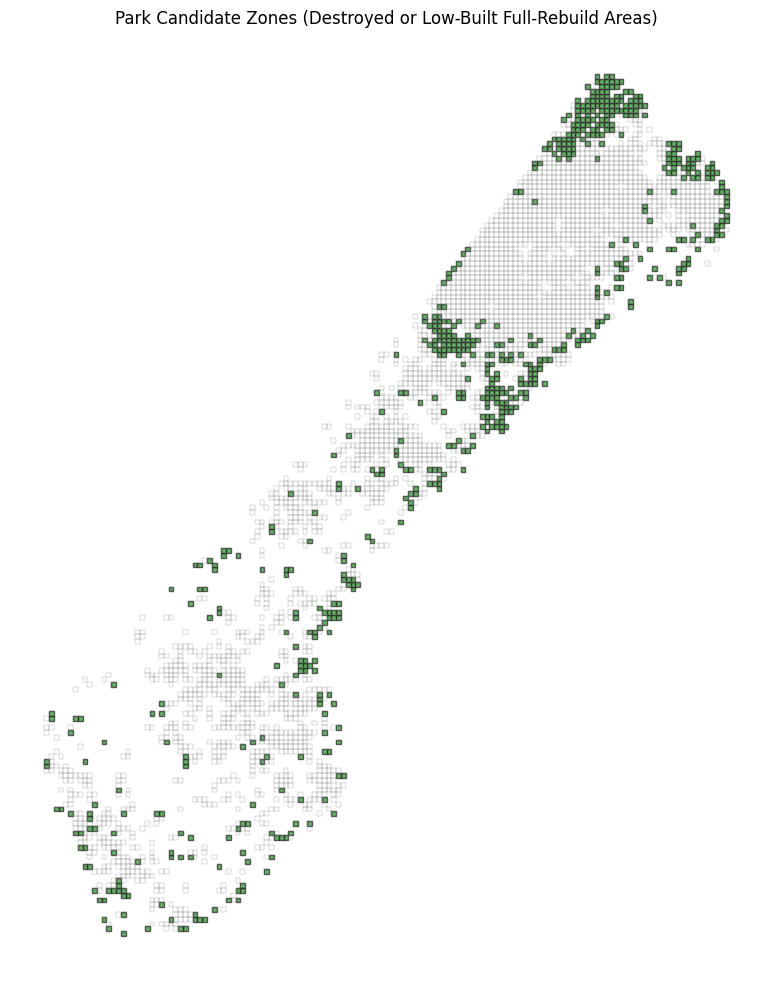

In [ ]:
#@title 5. Identify Empty Zones for Parks

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load data
grid = gpd.read_file("/content/drive/MyDrive/final/reconstruction_zones.gpkg")
gdf = gpd.read_file("/content/drive/MyDrive/final/buildings_with_predictions.gpkg")

# Ensure consistent projection (metric for area calculation)
grid = grid.to_crs(epsg=3857)
gdf = gdf.to_crs(epsg=3857)

# Step 1: Calculate building footprint area and assign to grid
gdf['footprint_area'] = gdf.geometry.area
gdf['destroyed'] = (gdf['model_pred_label'] == 1).astype(int)

# Step 2: Spatial join buildings to grid
gdf['building_id'] = gdf.index
joined = gpd.sjoin(gdf[['building_id', 'footprint_area', 'destroyed', 'geometry']],
                   grid[['geometry']], how='left', predicate='intersects')

# Step 3: Aggregate by grid cell
summary = joined.groupby(joined.index_right).agg({
    'building_id': 'count',
    'footprint_area': 'sum',
    'destroyed': 'sum'
}).rename(columns={
    'building_id': 'building_count',
    'footprint_area': 'total_footprint_area',
    'destroyed': 'destroyed_count'
})
summary['pct_destroyed'] = summary['destroyed_count'] / summary['building_count'].replace(0, np.nan)

# Step 4: Merge into grid
grid['grid_id'] = grid.index
grid = grid.merge(summary, left_on='grid_id', right_index=True, how='left')

# Fill missing values
grid[['building_count', 'total_footprint_area', 'destroyed_count', 'pct_destroyed']] = grid[[
    'building_count', 'total_footprint_area', 'destroyed_count', 'pct_destroyed'
]].fillna(0)

# Step 5: Identify potential park zones
# Criteria: full_rebuild zones where either destruction rate is high or footprint is low
is_full_rebuild = grid['rebuild_strategy'] == 'full_rebuild'
is_high_destruction = grid['pct_destroyed'] >= 0.75
is_low_footprint = grid['total_footprint_area'] < grid.geometry.area * 0.1  # less than 10% of cell built-up

park_candidates = grid[is_full_rebuild & (is_high_destruction | is_low_footprint)].copy()
park_candidates['proposed_use'] = 'green_space'

# Save to file
park_candidates.to_file("/content/drive/MyDrive/final/park_candidate_zones_refined.gpkg", driver='GPKG')

# Plot map
fig, ax = plt.subplots(figsize=(10, 10))
grid.boundary.plot(ax=ax, linewidth=0.2, color='gray')
park_candidates.plot(ax=ax, color='green', edgecolor='black', alpha=0.6)
plt.title("Park Candidate Zones (Destroyed or Low-Built Full-Rebuild Areas)")
plt.axis('off')
plt.tight_layout()
plt.show()


/tmp/ipython-input-20-2538447078.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged_geom = full_rebuild_zones.unary_union


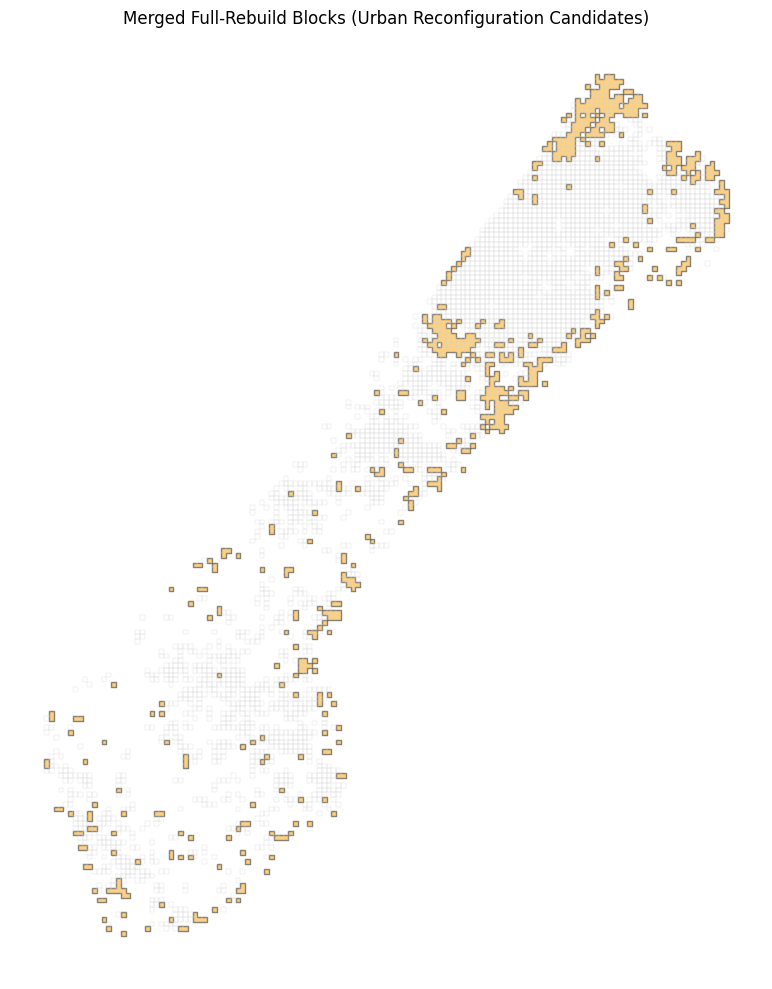

Number of merged blocks: 249
   block_id  block_area_m2  building_count
0         0        62500.0               5
1         1       125000.0               3
2         2        62500.0               1
3         3        62500.0               1
4         4       250000.0              15


In [ ]:
#@title 6. Merge and Analyze Full-Rebuild Zones
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# Load reconstruction grid and buildings again if needed
grid = gpd.read_file("/content/drive/MyDrive/final/reconstruction_zones.gpkg")
buildings = gpd.read_file("/content/drive/MyDrive/final/buildings_with_predictions.gpkg")

# Ensure same CRS for spatial ops
grid = grid.to_crs(epsg=3857)
buildings = buildings.to_crs(grid.crs)

# Step 1: Select only full_rebuild zones
full_rebuild_zones = grid[grid['rebuild_strategy'] == 'full_rebuild'].copy()

# Step 2: Merge adjacent cells into contiguous urban blocks
# First dissolve all full_rebuild cells into multipolygon
merged_geom = full_rebuild_zones.unary_union

# Explode into individual polygons (blocks)
merged_blocks = gpd.GeoDataFrame(geometry=[geom for geom in merged_geom.geoms],
                                  crs=grid.crs)

# Add area and unique ID
merged_blocks["block_area_m2"] = merged_blocks.geometry.area
merged_blocks["block_id"] = merged_blocks.index

# Step 3: Count how many buildings are within each merged block
# Spatial join buildings to blocks
buildings = buildings.copy()
buildings['building_id'] = buildings.index  # track

joined = gpd.sjoin(buildings[['building_id', 'geometry']],
                   merged_blocks[['block_id', 'geometry']],
                   how='inner', predicate='intersects')

# Aggregate counts
building_counts = joined.groupby("block_id").size().reset_index(name="building_count")
merged_blocks = merged_blocks.merge(building_counts, on="block_id", how="left")
merged_blocks["building_count"] = merged_blocks["building_count"].fillna(0)

# Optional: Filter for meaningful blocks only (e.g., size > 1000m2)
merged_blocks = merged_blocks[merged_blocks["block_area_m2"] > 1000].copy()

# Step 4: Save and visualize
merged_blocks.to_file("/content/drive/MyDrive/final/merged_rebuild_blocks.gpkg", driver="GPKG")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
grid.boundary.plot(ax=ax, linewidth=0.2, color='lightgray')
merged_blocks.plot(ax=ax, color='orange', edgecolor='black', alpha=0.5)
plt.title("Merged Full-Rebuild Blocks (Urban Reconfiguration Candidates)")
plt.axis('off')
plt.tight_layout()
plt.show()

# Optional summary
print(f"Number of merged blocks: {len(merged_blocks)}")
print(merged_blocks[["block_id", "block_area_m2", "building_count"]].head())

In [ ]:
#@title 7. Estimate Material Volume and Embodied Carbon from Merged Blocks and Building Geometry

import geopandas as gpd
import pandas as pd
import numpy as np

# --- 1. Load Data ---

# Load merged full-rebuild blocks
merged_blocks = gpd.read_file('/content/drive/MyDrive/final/merged_rebuild_blocks.gpkg')

# Load buildings with geometry and minimal fields
buildings_gdf = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions.gpkg')

# Handle missing 'height' or 'building' safely
if 'height' not in buildings_gdf.columns:
    buildings_gdf['height'] = 10
if 'building' not in buildings_gdf.columns:
    buildings_gdf['building'] = 'unknown'

# Ensure CRS consistency
if merged_blocks.crs != buildings_gdf.crs:
    buildings_gdf = buildings_gdf.to_crs(merged_blocks.crs)

# --- 2. Spatial Join: Match buildings to full-rebuild blocks ---
joined = gpd.sjoin(buildings_gdf, merged_blocks[['block_id', 'geometry']], how='inner', predicate='within')

# --- 3. Estimate Dimensions and Volume ---
joined['building_area_m2'] = joined.geometry.area
joined['estimated_height_m'] = joined['height'].fillna(10)
joined['estimated_volume_m3'] = joined['building_area_m2'] * joined['estimated_height_m']

# --- 4. Typology-Specific Material Intensities (assumed ratios by volume per typology) ---
# You may refine these based on typology standards or Gaza-specific reports
material_ratios = {
    'residential': {'cement': 0.30, 'steel': 0.10, 'sand': 0.20, 'stone': 0.15, 'gravel': 0.15, 'lumber': 0.05, 'water': 0.05},
    'commercial':  {'cement': 0.35, 'steel': 0.15, 'sand': 0.15, 'stone': 0.10, 'gravel': 0.15, 'lumber': 0.05, 'water': 0.05},
    'educational': {'cement': 0.32, 'steel': 0.12, 'sand': 0.18, 'stone': 0.12, 'gravel': 0.16, 'lumber': 0.05, 'water': 0.05},
    'unknown':     {'cement': 0.33, 'steel': 0.12, 'sand': 0.17, 'stone': 0.13, 'gravel': 0.15, 'lumber': 0.05, 'water': 0.05}
}

# --- 5. Predicted 2025 Material Costs ---
unit_costs = {
    'cement': 75.06,     # USD/ton
    'steel': 1100.81,
    'sand': 35.03,
    'stone': 56.04,
    'gravel': 21.02,
    'lumber': 300.22,    # USD/m³
    'water': 3.00,       # USD/m³
    'labor': 202.39      # USD/m²
}

# --- 6. Compute Material Quantities and Costs ---
def compute_costs(row):
    typology = row['building'] if row['building'] in material_ratios else 'unknown'
    volume = row['estimated_volume_m3']
    area = row['building_area_m2']
    ratios = material_ratios[typology]

    materials = {mat: volume * ratio for mat, ratio in ratios.items()}
    costs = {mat: qty * unit_costs[mat] for mat, qty in materials.items() if mat in unit_costs}
    total_cost = sum(costs.values()) + unit_costs['labor'] * area

    return pd.Series({
        'total_material_cost_usd': total_cost,
        'cement_tons': materials['cement'],
        'steel_tons': materials['steel'],
        'sand_tons': materials['sand'],
        'stone_tons': materials['stone'],
        'gravel_tons': materials['gravel'],
        'lumber_m3': materials['lumber'],
        'water_m3': materials['water']
    })

cost_results = joined.apply(compute_costs, axis=1)
joined = pd.concat([joined, cost_results], axis=1)

# --- 7. Aggregate by Block ---
block_summary = (
    joined.groupby('block_id')
    .agg(
        total_area_m2=('building_area_m2', 'sum'),
        avg_height_m=('estimated_height_m', 'mean'),
        total_volume_m3=('estimated_volume_m3', 'sum'),
        total_cost_usd=('total_material_cost_usd', 'sum'),
        cement_tons=('cement_tons', 'sum'),
        steel_tons=('steel_tons', 'sum'),
        sand_tons=('sand_tons', 'sum'),
        stone_tons=('stone_tons', 'sum'),
        gravel_tons=('gravel_tons', 'sum'),
        lumber_m3=('lumber_m3', 'sum'),
        water_m3=('water_m3', 'sum'),
        building_count=('building_area_m2', 'count')
    )
    .reset_index()
)

# Estimate carbon footprint (cement + steel are main contributors)
carbon_factors = {'cement': 0.93, 'steel': 1.85}  # kg CO₂ per kg
block_summary['embodied_carbon_kg'] = (
    block_summary['cement_tons'] * 1000 * carbon_factors['cement'] +
    block_summary['steel_tons'] * 1000 * carbon_factors['steel']
)

# --- 8. Merge Results into GeoDataFrame ---
merged_blocks = merged_blocks.merge(block_summary, on='block_id', how='left')

# --- 9. Save to Disk ---
output_path = '/content/drive/MyDrive/final/full_rebuild_blocks_with_typology_costs.gpkg'
merged_blocks.to_file(output_path, driver='GPKG')
print(f" Saved enriched material + cost estimates to:\n{output_path}")

# --- 10. Preview ---
cols = [col for col in merged_blocks.columns if 'building_count' in col]
print("Detected building count columns:", cols)

preview_cols = ['block_id', 'total_cost_usd', 'embodied_carbon_kg'] + cols
merged_blocks[preview_cols].head()

 Saved enriched material + cost estimates to:
/content/drive/MyDrive/final/full_rebuild_blocks_with_typology_costs.gpkg
Detected building count columns: ['building_count_x', 'building_count_y']


,block_id,total_cost_usd,embodied_carbon_kg,building_count_x,building_count_y
0,0,1.873375e+06,4.748521e+06,5,5.0
1,1,4.188920e+05,1.061783e+06,3,3.0
2,2,2.084186e+05,5.282874e+05,1,1.0
3,3,NaN,NaN,1,NaN
4,4,3.295561e+06,8.353396e+06,15,13.0


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


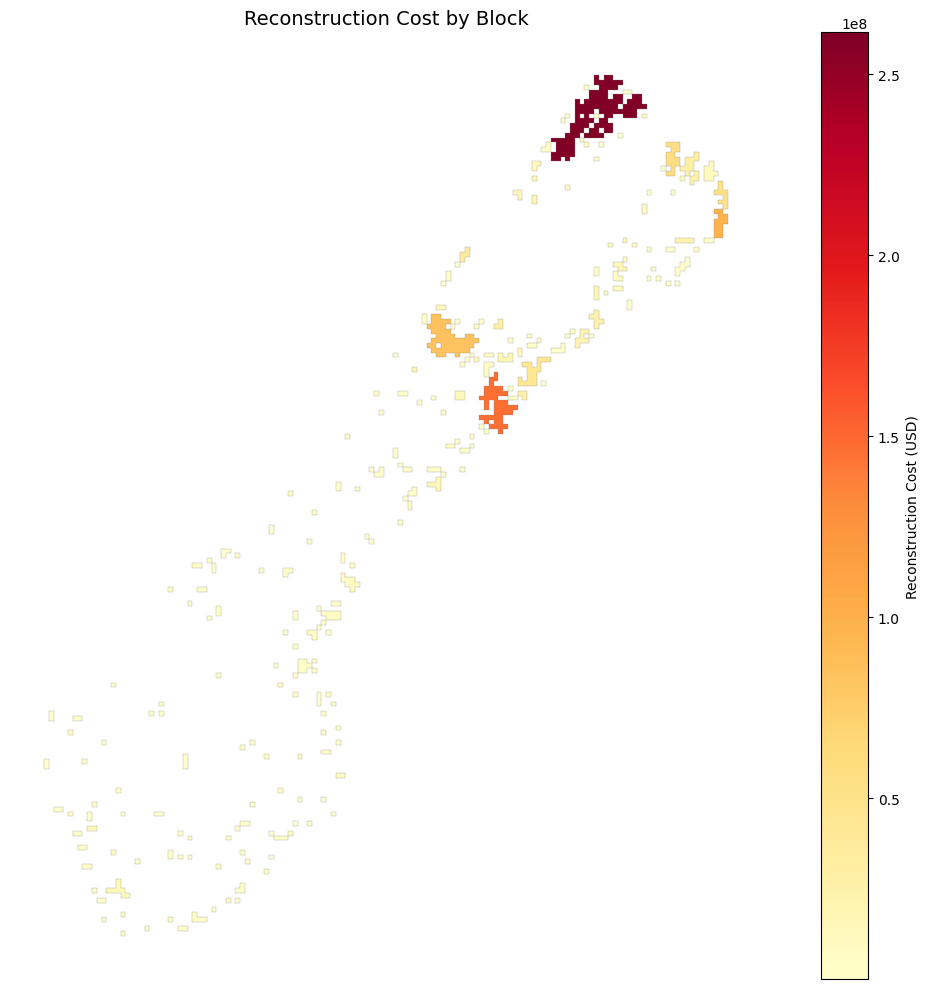

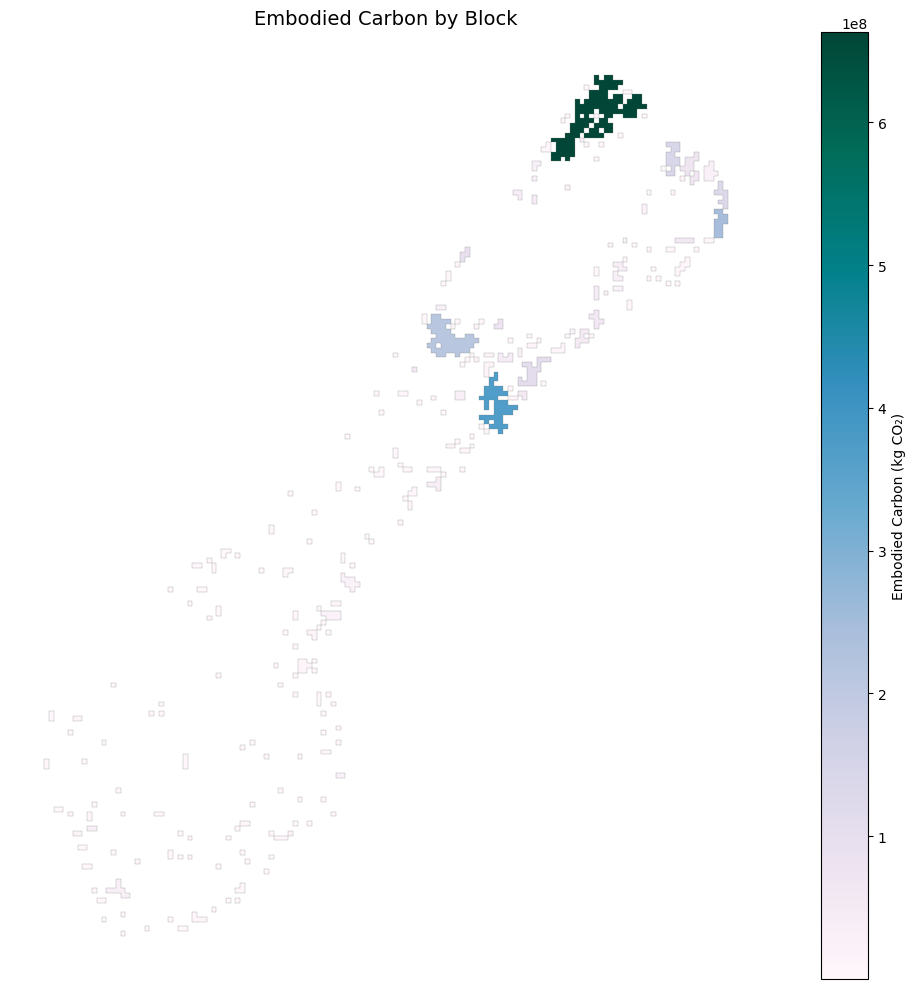

In [ ]:
#@title 8. Visualize Reconstruction Cost and Carbon Hotspots

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Mount Google Drive (only needed once per session)
from google.colab import drive
drive.mount('/content/drive')

# --- 1. Load GeoDataFrame ---
gpkg_path = '/content/drive/MyDrive/final/full_rebuild_blocks_with_typology_costs.gpkg'
gdf = gpd.read_file(gpkg_path)

# --- 2. Clean Missing Values ---
gdf = gdf.dropna(subset=['total_cost_usd', 'embodied_carbon_kg'])

# --- 3. Plot Reconstruction Cost ---
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(column='total_cost_usd',
         cmap='YlOrRd',
         linewidth=0.2,
         edgecolor='grey',
         legend=True,
         ax=ax,
         legend_kwds={'label': "Reconstruction Cost (USD)",
                      'orientation': "vertical"})
ax.set_title("Reconstruction Cost by Block", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# --- 4. Plot Embodied Carbon ---
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(column='embodied_carbon_kg',
         cmap='PuBuGn',
         linewidth=0.2,
         edgecolor='grey',
         legend=True,
         ax=ax,
         legend_kwds={'label': "Embodied Carbon (kg CO₂)",
                      'orientation': "vertical"})
ax.set_title("Embodied Carbon by Block", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()



Top 15 Blocks by Total Cost:


,block_id,total_cost_usd,building_count_x,cost_per_m2
195,195,2.615623e+08,893,35.168036
166,166,1.466360e+08,353,53.322191
240,240,9.779736e+07,254,120.365976
141,141,8.447526e+07,216,27.032083
230,230,5.703793e+07,296,57.037929
243,243,5.025439e+07,130,89.341130
172,172,4.302269e+07,77,38.242387
165,165,3.706971e+07,26,148.278821
179,179,3.056047e+07,85,162.989163
248,248,2.961276e+07,92,47.380413



Top 15 Blocks by Embodied Carbon:


,block_id,embodied_carbon_kg,building_count_x,carbon_per_m2
195,195,6.629928e+08,893,89.141893
166,166,3.716845e+08,353,135.157991
240,240,2.478911e+08,254,305.096680
141,141,2.141230e+08,216,68.519352
230,230,1.445764e+08,296,144.576428
243,243,1.273819e+08,130,226.456704
172,172,1.090514e+08,77,96.934579
165,165,9.396213e+07,26,375.848538
179,179,7.746290e+07,85,413.135456
248,248,7.506070e+07,92,120.097117



Top 15 Blocks by Cost Efficiency (USD per m²):


,block_id,total_cost_usd,area_m2,cost_per_m2
102,102,17520.358666,62500.0,0.280326
69,69,22939.311351,62500.0,0.367029
53,53,26742.819488,62500.0,0.427885
48,48,34184.870290,62500.0,0.546958
183,183,35574.655771,62500.0,0.569194
33,33,43931.684958,62500.0,0.702907
211,211,102469.815290,125000.0,0.819759
105,105,51260.107320,62500.0,0.820162
111,111,54100.446334,62500.0,0.865607
112,112,58660.482658,62500.0,0.938568



Top 15 Blocks by Carbon Efficiency (kg CO₂ per m²):


,block_id,embodied_carbon_kg,area_m2,carbon_per_m2
102,102,44409.586770,62500.0,0.710553
69,69,58145.233058,62500.0,0.930324
53,53,67786.144405,62500.0,1.084578
48,48,86649.822205,62500.0,1.386397
183,183,90172.569660,62500.0,1.442761
33,33,111355.481491,62500.0,1.781688
211,211,259734.531710,125000.0,2.077876
105,105,129931.140526,62500.0,2.078898
111,111,137130.666763,62500.0,2.194091
112,112,148689.181784,62500.0,2.379027


/tmp/ipython-input-31-4029797837.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipython-input-31-4029797837.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


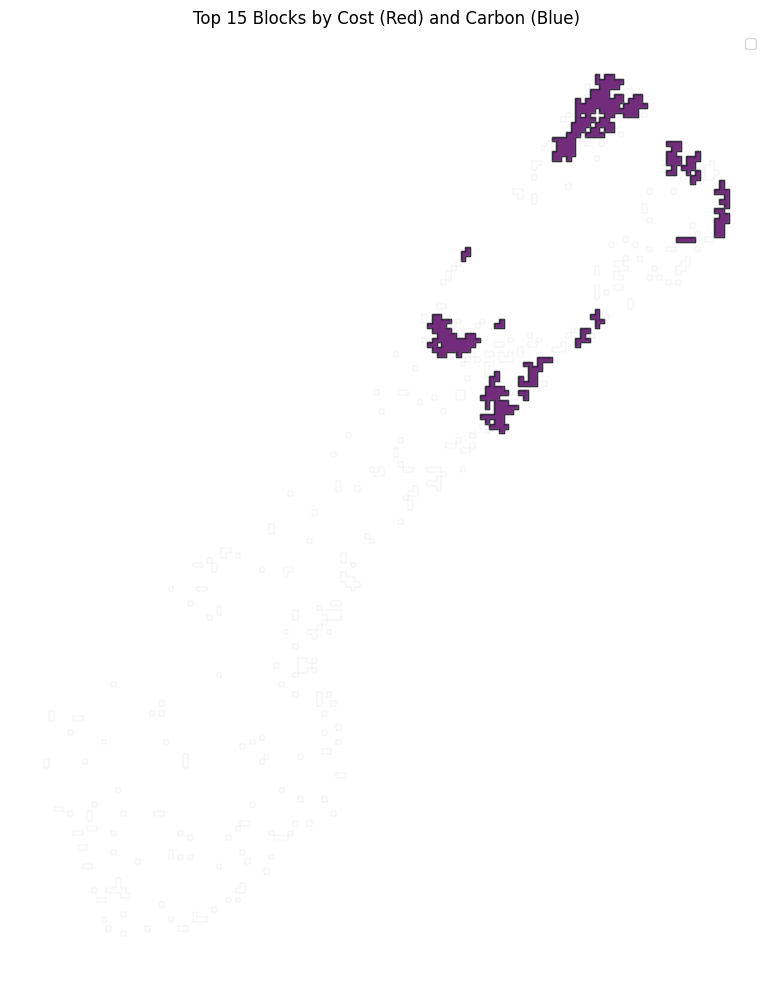

Saved block priority ranking summaries to: /content/drive/MyDrive/final/block_priority_rankings.csv


In [ ]:
#@title 9. Block Prioritization: Ranking by Cost, Carbon, and Efficiency

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load Processed GeoDataFrame ---
gpkg_path = '/content/drive/MyDrive/final/full_rebuild_blocks_with_typology_costs.gpkg'
gdf = gpd.read_file(gpkg_path)

# --- 2. Calculate Derived Metrics ---
# Avoid division by zero
gdf['area_m2'] = gdf.geometry.area
gdf['cost_per_m2'] = gdf['total_cost_usd'] / gdf['area_m2']
gdf['carbon_per_m2'] = gdf['embodied_carbon_kg'] / gdf['area_m2']
gdf['cost_per_building'] = gdf['total_cost_usd'] / gdf['building_count_x'].replace(0, np.nan)
gdf['carbon_per_building'] = gdf['embodied_carbon_kg'] / gdf['building_count_x'].replace(0, np.nan)

# --- 3. Ranking: Get Top 15 by Various Criteria ---
top_cost = gdf.nlargest(15, 'total_cost_usd')
top_carbon = gdf.nlargest(15, 'embodied_carbon_kg')
top_efficiency = gdf.nsmallest(15, 'cost_per_m2')
top_carbon_eff = gdf.nsmallest(15, 'carbon_per_m2')

# --- 4. Output Summary Tables ---
print("\nTop 15 Blocks by Total Cost:")
display(top_cost[['block_id', 'total_cost_usd', 'building_count_x', 'cost_per_m2']])

print("\nTop 15 Blocks by Embodied Carbon:")
display(top_carbon[['block_id', 'embodied_carbon_kg', 'building_count_x', 'carbon_per_m2']])

print("\nTop 15 Blocks by Cost Efficiency (USD per m²):")
display(top_efficiency[['block_id', 'total_cost_usd', 'area_m2', 'cost_per_m2']])

print("\nTop 15 Blocks by Carbon Efficiency (kg CO₂ per m²):")
display(top_carbon_eff[['block_id', 'embodied_carbon_kg', 'area_m2', 'carbon_per_m2']])

# --- 5. Optional: Visualize Top Blocks on Map ---

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.boundary.plot(ax=ax, color='lightgrey', linewidth=0.2)
top_cost.plot(ax=ax, color='crimson', edgecolor='black', alpha=0.7, label='Top Cost')
top_carbon.plot(ax=ax, color='navy', edgecolor='black', alpha=0.5, label='Top Carbon')
plt.legend()
ax.set_title("Top 15 Blocks by Cost (Red) and Carbon (Blue)")
ax.axis('off')
plt.tight_layout()
plt.show()

# --- 6. Save Rankings as CSV for Further Analysis ---
summary_df = pd.concat([
    top_cost[['block_id', 'total_cost_usd', 'cost_per_m2']].assign(metric='top_cost'),
    top_carbon[['block_id', 'embodied_carbon_kg', 'carbon_per_m2']].assign(metric='top_carbon'),
    top_efficiency[['block_id', 'total_cost_usd', 'cost_per_m2']].assign(metric='top_cost_efficiency'),
    top_carbon_eff[['block_id', 'embodied_carbon_kg', 'carbon_per_m2']].assign(metric='top_carbon_efficiency')
])
summary_df.to_csv('/content/drive/MyDrive/final/block_priority_rankings.csv', index=False)
print("Saved block priority ranking summaries to: /content/drive/MyDrive/final/block_priority_rankings.csv")

Mounted at /content/drive
     block_id  total_cost_usd  building_count_x  cost_per_m2
195       195    2.615623e+08               893    35.168036
166       166    1.466360e+08               353    53.322191
240       240    9.779736e+07               254   120.365976
141       141    8.447526e+07               216    27.032083
230       230    5.703793e+07               296    57.037929
243       243    5.025439e+07               130    89.341130
172       172    4.302269e+07                77    38.242387
165       165    3.706971e+07                26   148.278821
179       179    3.056047e+07                85   162.989163
248       248    2.961276e+07                92    47.380413


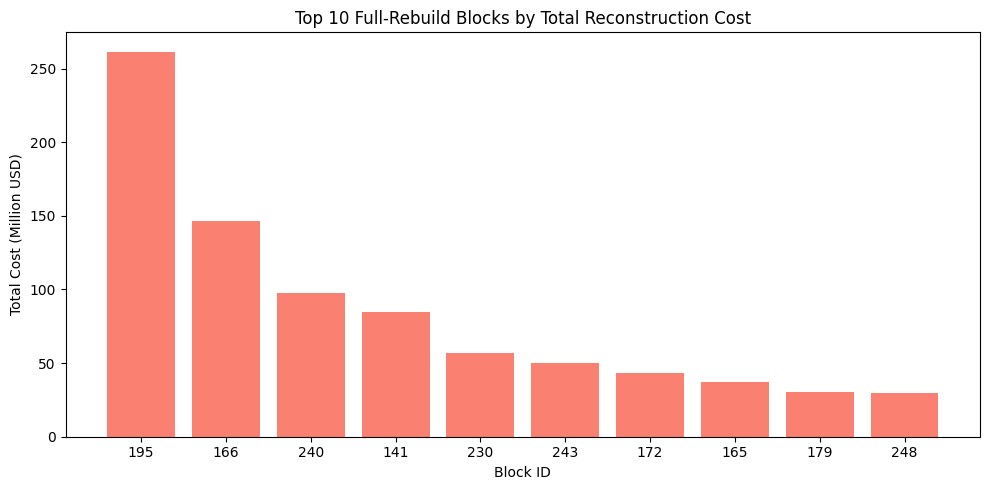

In [ ]:
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Make sure to load your GeoDataFrame if not already in memory
import geopandas as gpd
merged_blocks = gpd.read_file('/content/drive/MyDrive/final/full_rebuild_blocks_with_typology_costs.gpkg')

# If 'cost_per_m2' does not exist, calculate it
if 'cost_per_m2' not in merged_blocks.columns:
    merged_blocks['cost_per_m2'] = merged_blocks['total_cost_usd'] / merged_blocks['block_area_m2']

top10_cost = merged_blocks.nlargest(10, 'total_cost_usd')[['block_id', 'total_cost_usd', 'building_count_x', 'cost_per_m2']]
print(top10_cost)

# Bar chart
plt.figure(figsize=(10, 5))
plt.bar(top10_cost['block_id'].astype(str), top10_cost['total_cost_usd'] / 1e6, color='salmon')
plt.xlabel("Block ID")
plt.ylabel("Total Cost (Million USD)")
plt.title("Top 10 Full-Rebuild Blocks by Total Reconstruction Cost")
plt.tight_layout()
plt.show()


In [ ]:
total_cost_usd = merged_blocks['total_cost_usd'].sum()
print(f"Total full-rebuild reconstruction cost: ${total_cost_usd:,.0f} USD")

Total full-rebuild reconstruction cost: $1,511,561,810 USD


In [ ]:
import geopandas as gpd

# Load your blocks and building-level prediction files
merged_blocks = gpd.read_file('/content/drive/MyDrive/final/merged_rebuild_blocks.gpkg')
buildings_gdf = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions.gpkg')

# CRS check and match
if merged_blocks.crs != buildings_gdf.crs:
    buildings_gdf = buildings_gdf.to_crs(merged_blocks.crs)

# If missing columns, fill as before
if 'height' not in buildings_gdf.columns:
    buildings_gdf['height'] = 10
if 'building' not in buildings_gdf.columns:
    buildings_gdf['building'] = 'unknown'

# Compute area
buildings_gdf['building_area_m2'] = buildings_gdf.geometry.area

# Spatial join buildings to blocks
joined = gpd.sjoin(buildings_gdf, merged_blocks[['block_id', 'geometry']], how='inner', predicate='within')


In [ ]:
# Define BIC/BIM ratios (from the ScienceDirect article)
bic_ratios = {
    'residential': 823,
    'commercial': 1081,
    'educational': 1185,
    'healthcare': 1380,
    'unknown': 1000
}
bim_carbon_ratios = {
    'residential': 486,
    'commercial': 536,
    'educational': 573,
    'healthcare': 598,
    'unknown': 540
}

def assign_bic_bim(row):
    typ = row['building'] if row['building'] in bic_ratios else 'unknown'
    area = row['building_area_m2']
    bic = area * bic_ratios[typ]
    bim = area * bim_carbon_ratios[typ]
    return pd.Series({'bic_cost_usd': bic, 'bim_embodied_carbon_kg': bim})

# Apply per-building
joined[['bic_cost_usd', 'bim_embodied_carbon_kg']] = joined.apply(assign_bic_bim, axis=1)

# Aggregate to block
bicbim_summary = (
    joined.groupby('block_id')
    .agg(
        bic_cost_usd=('bic_cost_usd', 'sum'),
        bim_embodied_carbon_kg=('bim_embodied_carbon_kg', 'sum')
    )
    .reset_index()
)

# Merge and save
merged_blocks = merged_blocks.merge(bicbim_summary, on='block_id', how='left')
output_path = '/content/drive/MyDrive/final/full_rebuild_blocks_with_BIC_BIM_benchmarks.gpkg'
merged_blocks.to_file(output_path, driver='GPKG')
print("Saved with BIC/BIM benchmarks:", output_path)

Saved with BIC/BIM benchmarks: /content/drive/MyDrive/final/full_rebuild_blocks_with_BIC_BIM_benchmarks.gpkg


In [ ]:
print(merged_blocks[['block_id', 'block_area_m2', 'building_count', 'bic_cost_usd', 'bim_embodied_carbon_kg']].head())

   block_id  block_area_m2  building_count  bic_cost_usd  \
0         0        62500.0               5  8.978108e+05   
1         1       125000.0               3  2.007531e+05   
2         2        62500.0               1  9.988418e+04   
3         3        62500.0               1           NaN   
4         4       250000.0              15  1.579391e+06   

   bim_embodied_carbon_kg  
0           484817.848474  
1           108406.665988  
2            53937.455449  
3                     NaN  
4           852870.883677  


In [ ]:
print("TOTAL (BIC/BIM) Reconstruction Cost: ${:,.0f} USD".format(merged_blocks['bic_cost_usd'].sum()))
print("TOTAL (BIC/BIM) Embodied Carbon: {:,.0f} kg CO₂".format(merged_blocks['bim_embodied_carbon_kg'].sum()))

TOTAL (BIC/BIM) Reconstruction Cost: $724,412,746 USD
TOTAL (BIC/BIM) Embodied Carbon: 391,182,883 kg CO₂


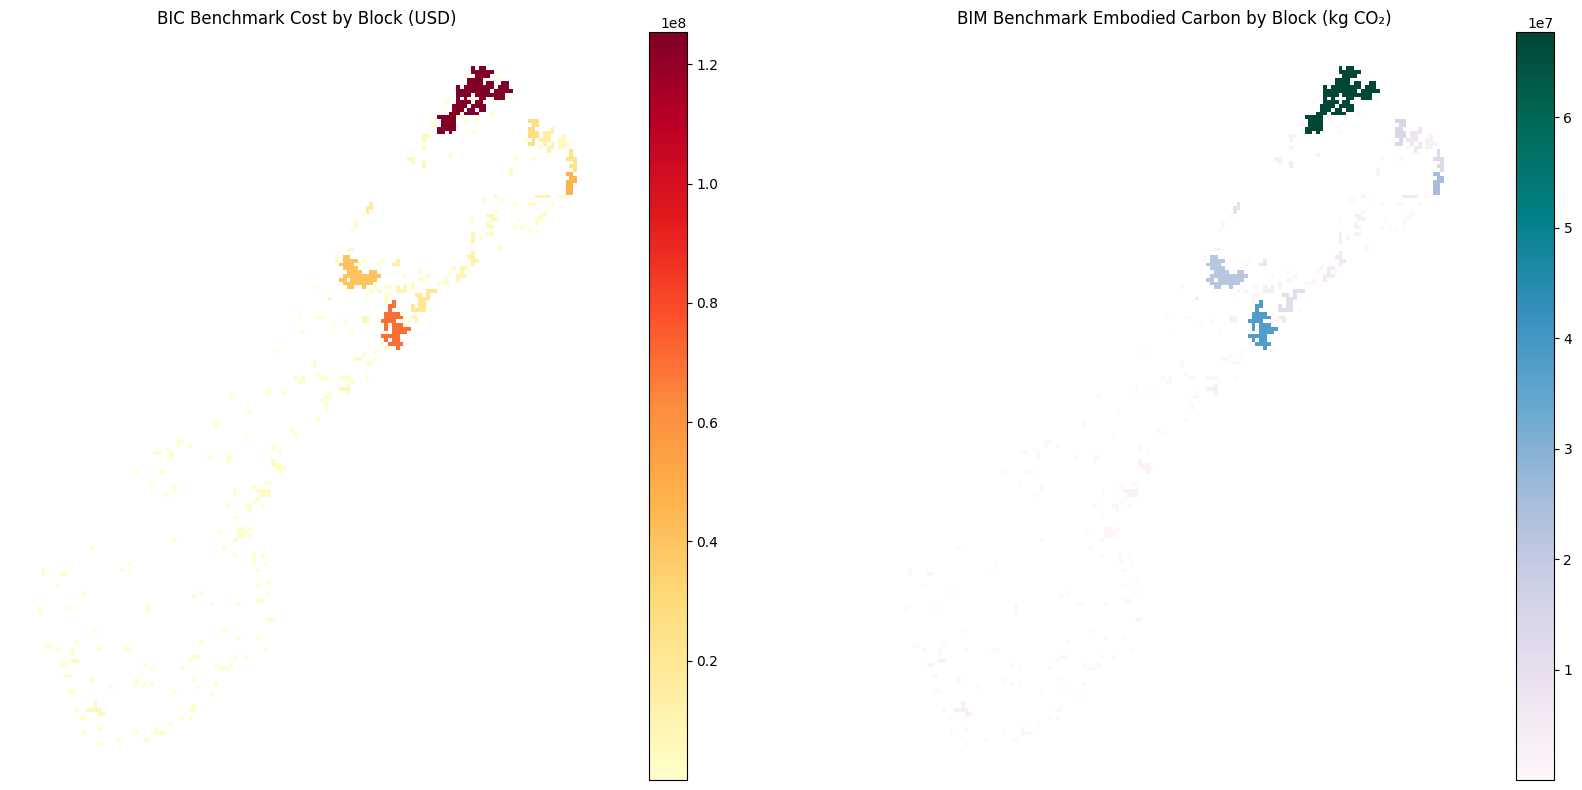

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
merged_blocks.plot(column='bic_cost_usd', cmap='YlOrRd', legend=True, ax=ax1)
ax1.set_title('BIC Benchmark Cost by Block (USD)')
ax1.axis('off')

merged_blocks.plot(column='bim_embodied_carbon_kg', cmap='PuBuGn', legend=True, ax=ax2)
ax2.set_title('BIM Benchmark Embodied Carbon by Block (kg CO₂)')
ax2.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [ ]:
# Load building polygons and predictions
buildings_gdf = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions.gpkg')

# Check and add missing fields as needed
if 'building' not in buildings_gdf.columns:
    buildings_gdf['building'] = 'unknown'
if 'levels' not in buildings_gdf.columns:
    # Use 'building:levels' if available, else 1
    col_guess = [col for col in buildings_gdf.columns if 'level' in col]
    if col_guess:
        buildings_gdf['levels'] = pd.to_numeric(buildings_gdf[col_guess[0]], errors='coerce')
    else:
        buildings_gdf['levels'] = 1
buildings_gdf['levels'] = buildings_gdf['levels'].fillna(1).astype(float)

In [ ]:
# Basic mapping - expand as your data allows
typology_map = {
    'house': 'single_family',
    'detached': 'single_family',
    'residential': 'multi_family',      # or single_family if appropriate
    'apartments': 'multi_family',
    'commercial': 'commercial',
    'school': 'educational',
    'education': 'educational',
    'university': 'educational',
    'hospital': 'healthcare',
    'clinic': 'healthcare',
    # You can add 'industrial', 'mosque', etc., as needed
}
# Apply mapping; default to 'unknown'
buildings_gdf['typology'] = buildings_gdf['building'].map(typology_map).fillna('unknown')

In [ ]:
bic_ratios = {
    'single_family': 800,     # USD/m²
    'multi_family': 950,
    'commercial': 1100,
    'educational': 1200,
    'healthcare': 1350,
    'unknown': 1000           # fallback
}
bim_carbon_ratios = {
    'single_family': 450,     # kg CO2/m²
    'multi_family': 500,
    'commercial': 525,
    'educational': 575,
    'healthcare': 600,
    'unknown': 540
}

In [ ]:
buildings_gdf['footprint_area_m2'] = buildings_gdf.geometry.area
buildings_gdf['gross_floor_area_m2'] = buildings_gdf['footprint_area_m2'] * buildings_gdf['levels']

In [ ]:
# Apply per-building
buildings_gdf['core_cost_usd'] = [
    bic_ratios[t] * a for t, a in zip(buildings_gdf['typology'], buildings_gdf['gross_floor_area_m2'])
]
buildings_gdf['core_carbon_kg'] = [
    bim_carbon_ratios[t] * a for t, a in zip(buildings_gdf['typology'], buildings_gdf['gross_floor_area_m2'])
]

In [ ]:
# Adjust these percentages for your local context or reporting needs
SOFT_COST = 0.20        # 20% of core
CONTINGENCY = 0.50      # 50% of core (risk, import, security, delay)
INFRA_PER_M2 = 250      # USD/m² for urban infrastructure/utilities

buildings_gdf['soft_cost_usd'] = buildings_gdf['core_cost_usd'] * SOFT_COST
buildings_gdf['contingency_usd'] = buildings_gdf['core_cost_usd'] * CONTINGENCY
buildings_gdf['infra_share_usd'] = buildings_gdf['gross_floor_area_m2'] * INFRA_PER_M2

# Total "all-in" cost
buildings_gdf['total_cost_usd'] = (
    buildings_gdf['core_cost_usd'] +
    buildings_gdf['soft_cost_usd'] +
    buildings_gdf['contingency_usd'] +
    buildings_gdf['infra_share_usd']
)

# Embodied carbon (core only, since infra is often not included in building LCA)
buildings_gdf['total_carbon_kg'] = buildings_gdf['core_carbon_kg']

In [ ]:
# Estimate dwelling units if not already in data
# Assumption: 100m² per unit for multi-family, 150m² per unit for single-family (customize as needed)
buildings_gdf['units'] = np.where(
    buildings_gdf['typology'] == 'multi_family',
    np.maximum((buildings_gdf['gross_floor_area_m2'] / 100).round(), 1),
    np.where(
        buildings_gdf['typology'] == 'single_family',
        np.maximum((buildings_gdf['gross_floor_area_m2'] / 150).round(), 1),
        1
    )
)

In [ ]:
output_path = '/content/drive/MyDrive/final/buildings_detailed_costs_typologies.gpkg'
buildings_gdf.to_file(output_path, driver='GPKG')
print(f"Saved detailed cost & carbon results to: {output_path}")

Saved detailed cost & carbon results to: /content/drive/MyDrive/final/buildings_detailed_costs_typologies.gpkg


In [ ]:
# Macro totals
print("TOTAL (All-in) Cost: ${:,.0f}".format(buildings_gdf['total_cost_usd'].sum()))
print("TOTAL Embodied Carbon: {:,.0f} kg CO₂".format(buildings_gdf['total_carbon_kg'].sum()))

# By typology breakdown
print("\n--- Cost by Typology ---")
print(buildings_gdf.groupby('typology')['total_cost_usd'].sum().sort_values(ascending=False))

TOTAL (All-in) Cost: $16,482,202,818
TOTAL Embodied Carbon: 4,564,302,319 kg CO₂

--- Cost by Typology ---
typology
unknown    1.648220e+10
Name: total_cost_usd, dtype: float64


In [ ]:
if 'block_id' in buildings_gdf.columns:
    block_summary = buildings_gdf.groupby('block_id').agg(
        total_gfa_m2=('gross_floor_area_m2', 'sum'),
        total_buildings=('building', 'count'),
        total_units=('units', 'sum'),
        total_cost_usd=('total_cost_usd', 'sum'),
        total_carbon_kg=('total_carbon_kg', 'sum')
    ).reset_index()
    print(block_summary.head())

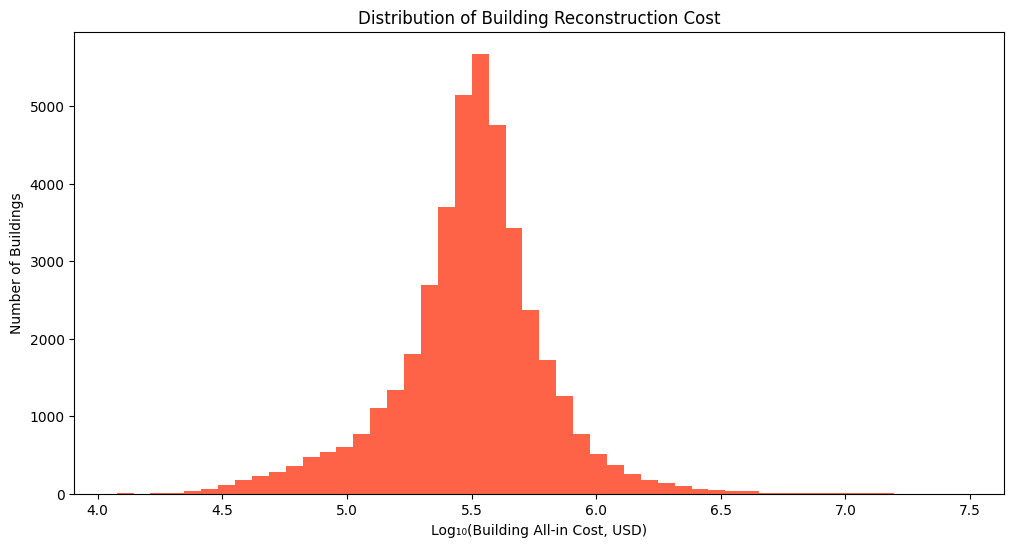

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.hist(np.log10(buildings_gdf['total_cost_usd']+1), bins=50, color='tomato')
plt.xlabel('Log₁₀(Building All-in Cost, USD)')
plt.ylabel('Number of Buildings')
plt.title('Distribution of Building Reconstruction Cost')
plt.show()

In [ ]:
#@title Cost and Carbon Estimation for Repair & Partial-Rebuild

# 1. Map building to strategy
def map_strategy(label):
    if label == 1:  # Destroyed
        return 'full_rebuild'
    elif label == 2:  # Damaged
        return 'partial_rebuild'
    else:  # Not Damaged
        return 'repair'

buildings_gdf['rebuild_strategy'] = buildings_gdf['model_pred_label'].apply(map_strategy)

# 2. Assign ratios
cost_ratios = {'repair': 0.20, 'partial_rebuild': 0.60, 'full_rebuild': 1.00}
carbon_ratios = {'repair': 0.10, 'partial_rebuild': 0.40, 'full_rebuild': 1.00}

# 3. Calculate adjusted costs/carbon
buildings_gdf['strategy_cost_usd'] = [
    cost_ratios[s] * c for s, c in zip(buildings_gdf['rebuild_strategy'], buildings_gdf['total_cost_usd'])
]
buildings_gdf['strategy_carbon_kg'] = [
    carbon_ratios[s] * c for s, c in zip(buildings_gdf['rebuild_strategy'], buildings_gdf['total_carbon_kg'])
]

# 4. Aggregate and save
summary = buildings_gdf.groupby('rebuild_strategy').agg(
    total_gfa_m2=('gross_floor_area_m2', 'sum'),
    building_count=('building', 'count'),
    total_cost_usd=('strategy_cost_usd', 'sum'),
    total_carbon_kg=('strategy_carbon_kg', 'sum')
).reset_index()

print(summary)

buildings_gdf.to_file('/content/drive/MyDrive/final/buildings_with_strategy_costs.gpkg', driver='GPKG')
summary.to_csv('/content/drive/MyDrive/final/summary_by_rebuild_strategy.csv', index=False)


Governorate assignment complete. Distribution:
governorate
Gaza             22213
North Gaza        9349
Deir al-Balah     4367
Khan Yunis        3683
Rafah             1617
Name: count, dtype: int64


KeyboardInterrupt: 

In [ ]:
ztotal_reconstruction_cost = buildings_gdf['strategy_cost_usd'].sum()
print("TOTAL Complete Reconstruction (Repair + Partial + Full): ${:,.0f} USD".format(total_reconstruction_cost))

TOTAL Complete Reconstruction (Repair + Partial + Full): $5,653,572,685 USD


 Section 3. Data Loading and Setup for Spatial Visualization and Analysis

In [ ]:
#@title 1. Setup and Library Installation
# Install GeoPandas and Streamlit (and other spatial tools as needed)
!pip install geopandas folium streamlit pydeck

# Colab sometimes needs this for pydeck maps
!pip install pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.9 MB/s eta 0:00:00


In [ ]:
#@title 2. Mount Google Drive and List Files
from google.colab import drive
drive.mount('/content/drive')

# List files in your data directory to verify paths
import os
data_dir = '/content/drive/MyDrive/final/' # CHANGE this to your real folder
print(os.listdir(data_dir))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['max_refined_ensemble_model.joblib', 'buildings_with_predictions.csv', 'buildings_with_predictions.gpkg', 'reconstruction_zones.gpkg', 'park_candidate_zones.gpkg', 'park_candidate_zones_refined.gpkg', 'merged_rebuild_blocks.gpkg', 'full_rebuild_blocks_carbon_cost.gpkg', 'full_rebuild_blocks_with_typology_costs.gpkg', 'block_priority_rankings.csv', 'full_rebuild_blocks_with_BIC_BIM_benchmarks.gpkg', 'buildings_detailed_costs_typologies.gpkg', 'buildings_with_strategy_costs.gpkg', 'summary_by_rebuild_strategy.csv']


In [ ]:
#@title 3. Load the Key Data
import geopandas as gpd
import pandas as pd

# Example file paths (update as needed)
buildings_fp = data_dir + 'buildings_with_strategy_costs.gpkg'
summary_fp = data_dir + 'summary_by_rebuild_strategy.csv'

# Load GeoPackage
buildings = gpd.read_file(buildings_fp)
print(buildings.head())

# Load summary
summary = pd.read_csv(summary_fp)
print(summary.head())

          id  building zone source  \
0   41312981        43   Z1   None   
1   41314445        43   Z1   None   
2   41314593        43   Z1   None   
3   41315311        25   Z1   None   
4  295837446        43   Z1   None   

                                                path  \
0  /Users/yousseffranci/Downloads/gaza_30zones/Z1...   
1  /Users/yousseffranci/Downloads/gaza_30zones/Z1...   
2  /Users/yousseffranci/Downloads/gaza_30zones/Z1...   
3  /Users/yousseffranci/Downloads/gaza_30zones/Z1...   
4  /Users/yousseffranci/Downloads/gaza_30zones/Z1...   

   Grouped_Damage_Classes_count  Grouped_Damage_Classes_unique  \
0                           1.0                            1.0   
1                           1.0                            1.0   
2                           1.0                            1.0   
3                           1.0                            1.0   
4                           1.0                            1.0   

   Grouped_Damage_Classes_min  Groupe

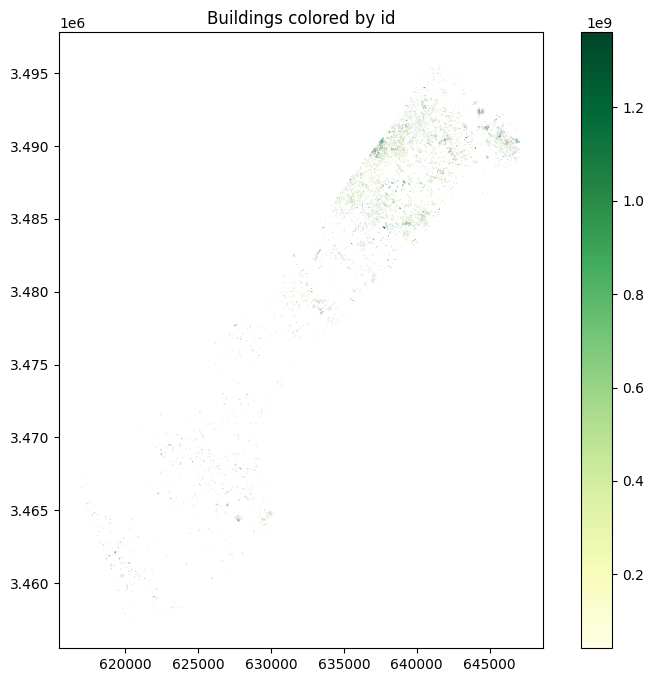

In [ ]:
#@title 4. Quick Map Visualization
import matplotlib.pyplot as plt

# Choose attribute to visualize (update as needed)
attribute = 'carbon_cost' if 'carbon_cost' in buildings.columns else buildings.columns[0]

buildings.plot(column=attribute, cmap='YlGn', legend=True, figsize=(10, 8))
plt.title(f'Buildings colored by {attribute}')
plt.show()

# Section 4. Metaheuristic Urban Optimization for Post-Conflict Gaza

This section describes an improved metaheuristic optimization strategy for reconstructing urban neighborhoods in Gaza using AI-driven, sustainability-focused design principles.

Unlike conventional models that unrealistically overpopulate schools, parks, and religious buildings, our approach prioritizes real-world proportions: 80–90% residential housing, 10–15% community infrastructure (schools, mosques, clinics), and 5–10% open/green spaces. Parks are designed as true green spaces—corridors, plazas, and gardens—integrated with walkability, accessibility, and local cultural patterns.

The optimization integrates debris reuse (transforming former destruction sites into parks or public amenities), maximizes housing, ensures service access, and applies advanced metaheuristic or generative algorithms, all while considering sustainability and the lived realities of Gaza’s urban fabric.

In [ ]:
#@title 1. Install and Import Libraries

# If using Google Colab, install necessary packages.
# (You may comment these out if running locally with everything pre-installed.)
%pip install --quiet geopandas pygad shapely openpyxl rasterio scikit-learn networkx

# Standard Data Science & Geospatial
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
import matplotlib.pyplot as plt

# Evolutionary Optimization
import pygad

# Utility and Random
import random
import os
import json

# For possible image processing and deep learning (for SSD, MRF, etc.)
import cv2
from skimage.transform import warp_polar
import torch

# For advanced spatial joins and raster handling (SAR, debris, parks)
import rasterio

# For graph/park assignment logic, typology, etc.
import networkx as nx

# For BIM/BIC pricing model if using machine learning
from sklearn.ensemble import HistGradientBoostingRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 59.7 MB/s eta 0:00:00


In [ ]:
#@title 2. Mount Drive and Load Data
# 2. Mount Drive and Load Data

# If in Google Colab, mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ---- PATHS ----
data_dir = '/content/drive/MyDrive/final/'  # Update if your directory differs
pop_file = data_dir + 'SheetJSTableExport (1).xlsx'
bim_bic_file = data_dir + 'forecasted_costs_2025.csv'  # For BIM/BIC pricing if needed

# ---- LOAD GEO DATA ----
# All main urban elements, ensure files exist in your drive!
buildings = gpd.read_file(data_dir + 'buildings_with_strategy_costs.gpkg')
blocks = gpd.read_file(data_dir + 'full_rebuild_blocks_carbon_cost.gpkg')
parks = gpd.read_file(data_dir + 'park_candidate_zones_refined.gpkg')
schools = gpd.read_file(data_dir + 'buildings_with_predictions.gpkg')

# Load BIM/BIC pricing/cost dataset (if you want to merge costs later)
try:
    bim_bic_df = pd.read_csv(bim_bic_file)
    print("Loaded BIM/BIC pricing data.")
except Exception as e:
    print("Could not load BIM/BIC pricing file:", e)
    bim_bic_df = None

# ---- LOAD POPULATION DATA ----
# Sheet 1 assumed to have main population/district info
pop_df = pd.read_excel(pop_file, engine='openpyxl')
print("Population data by district:\n", pop_df.head())

# ---- ENSURE CRS CONSISTENCY (for all spatial analysis) ----
target_crs = "EPSG:32636"  # Gaza UTM (adjust to match your region if different)
for gdf in [buildings, blocks, parks, schools]:
    if gdf.crs != target_crs:
        gdf.to_crs(target_crs, inplace=True)

print("All data loaded and projected to", target_crs)


Mounted at /content/drive
Loaded BIM/BIC pricing data.
Population data by district:
                   Main indicators Unnamed: 1  Unnamed: 2 Unnamed: 3
0                       indicator  the value        Unit       year
1            Estimated population    5227193     Persons       2021
2                       West Bank    3120448     Persons       2021
3                      Gaza strip    2106745     Persons       2021
4  Population aged under 18 years       44.2  Percentage       2021
All data loaded and projected to EPSG:32636


In [ ]:
#@title 3. Filter for Existent Buildings Only (using prediction columns)
# Load predicted building statuses (use this for ALL downstream analysis)
buildings = gpd.read_file(data_dir + 'buildings_with_predictions.gpkg')
print(f"Loaded {len(buildings)} buildings from predictions file.")

# Check which columns might represent damage or status.
print("Columns available:", list(buildings.columns))

# You likely have a column such as 'model_pred_label', 'damage_level', or similar
damage_col_candidates = ['model_pred_label', 'damage_level', 'Grouped_Damage_Classes_max', 'status']

found_col = None
for col in damage_col_candidates:
    if col in buildings.columns:
        found_col = col
        print(f"Using '{col}' to filter for existent buildings.")
        break

if found_col:
    # Usually 1 or 'Destroyed' means destroyed; 0 or 'Standing'/'Undamaged' means standing
    destroyed_values = ['destroyed', 'full_rebuild', 'ruin', 'demolished', 1, '1']
    existent_mask = ~buildings[found_col].astype(str).str.lower().isin([str(val).lower() for val in destroyed_values])
    buildings = buildings[existent_mask].copy()
    print(f"Filtered to {len(buildings)} existent buildings based on predictions.")
    print(buildings[found_col].value_counts(dropna=False))
else:
    print("No predicted damage/status column found. Keeping all buildings. Please check columns!")

# Optional: preview a few rows
print(buildings.head())


Loaded 41229 buildings from predictions file.
Columns available: ['id', 'building', 'zone', 'source', 'path', 'Grouped_Damage_Classes_count', 'Grouped_Damage_Classes_unique', 'Grouped_Damage_Classes_min', 'Grouped_Damage_Classes_max', 'Grouped_Damage_Classes_range', 'Grouped_Damage_Classes_sum', 'Grouped_Damage_Classes_mean', 'Grouped_Damage_Classes_median', 'Grouped_Damage_Classes_stddev', 'Grouped_Damage_Classes_minority', 'Grouped_Damage_Classes_majority', 'Grouped_Damage_Classes_q1', 'Grouped_Damage_Classes_q3', 'Grouped_Damage_Classes_iqr', 'Main_Damage_Site_Class_count', 'Main_Damage_Site_Class_unique', 'Main_Damage_Site_Class_sum', 'Main_Damage_Site_Class_2_count', 'Main_Damage_Site_Class_2_unique', 'Main_Damage_Site_Class_2_sum', 'Damage_Status_2_count', 'Damage_Status_2_unique', 'Damage_Status_2_sum', 'Main_Damage_Site_Class_3_count', 'Main_Damage_Site_Class_3_unique', 'Main_Damage_Site_Class_3_min', 'Main_Damage_Site_Class_3_max', 'Main_Damage_Site_Class_3_range', 'Main_Damag

In [ ]:
#@title 4. Assign current use/type by joining from master file

import pandas as pd
import geopandas as gpd

# 1. Load building types from the master file (ensure we use only 'id' and 'building')
main_gdf = gpd.read_file('/content/drive/MyDrive/damage_features_buildings_updated.gpkg')
main_gdf = main_gdf[['id', 'building']].copy()

# 2. Merge onto predictions-based buildings DataFrame, suffix for master
buildings = buildings.merge(main_gdf, on='id', how='left', suffixes=('', '_master'))

# 3. Remove any duplicate columns (from multiple merges, if any)
buildings = buildings.loc[:, ~buildings.columns.duplicated()]

# 4. Ensure we're using the correct column for the type string
if 'building_master' in buildings.columns:
    building_type_col = 'building_master'
else:
    raise ValueError("No 'building_master' column found after merge/deduplication.")

# 5. Define use mapping (update as your project needs)
use_map = {
    'residential': 0,
    'house': 0,
    'apartments': 0,
    'detached': 0,
    'yes': 0,  # Treat 'yes' as residential
    'public': 5,
    'community': 5,
    'school': 1,
    'college': 1,
    'university': 1,
    'kindergarten': 1,
    'mosque': 3,
    'religious': 3,
    'church': 3,
    'hospital': 4,
    'warehouse': 6,
    'industrial': 6,
    'commercial': 6,
    'retail': 6,
    'office': 6,
    'hotel': 6,
    'sports_centre': 6,
    'supermarket': 6,
    'farm': 6,
    'farm_auxiliary': 6,
    'bakehouse': 6,
    'garage': 6,
    'service': 6,
    'hangar': 6,
    'shed': 6,
    'roof': 6,
    'stable': 6,
    'cowshed': 6,
    'greengrocer': 6,
    'hut': 6,
    'tank': 6,
    'bunker': 6,
    'water_tower': 6,
    'greenhouse': 6,
    'greenhouse_horticulture': 6,
    'ruins': 6,
    'destroyed': 6,
    'grandstand': 6,
    'park': 2,
    'other': 6
}

def classify_use_final(raw_value):
    if pd.isnull(raw_value):
        return use_map['other']
    v = str(raw_value).strip().lower()
    if v in use_map:
        return use_map[v]
    if any(w in v for w in ['school', 'college', 'university', 'kindergarten']):
        return use_map['school']
    if any(w in v for w in ['mosque', 'church', 'religious']):
        return use_map['mosque']
    if 'hospital' in v:
        return use_map['hospital']
    if any(w in v for w in ['house', 'apartment', 'residential', 'detached']):
        return use_map['residential']
    if 'park' in v:
        return use_map['park']
    if any(w in v for w in ['public', 'community']):
        return use_map['community']
    return use_map['other']

# 6. Assign use code and readable label
buildings['current_use'] = buildings[building_type_col].astype(str).apply(classify_use_final)

label_map = {
    0: "residential",
    1: "school",
    2: "park",
    3: "mosque",
    4: "hospital",
    5: "community",
    6: "other"
}
buildings['current_use_label'] = buildings['current_use'].map(label_map).fillna('other')

# 7. Preview result
print("Unique building types from master file:", buildings[building_type_col].dropna().unique())
print("Distribution of assigned use types:")
print(buildings['current_use_label'].value_counts())
print(buildings[['id', building_type_col, 'current_use_label']].head(10))


Unique building types from master file: ['yes' 'mosque' 'industrial' 'commercial' 'residential' 'farm_auxiliary'
 'greenhouse' 'apartments' 'house' 'ruins' 'hotel' 'public' 'university'
 'office' 'roof' 'school' 'service' 'warehouse' 'construction' 'hospital'
 'garage' 'water_tower' 'supermarket' 'hut' 'kindergarten']
Distribution of assigned use types:
current_use_label
residential    145509
school           2104
other            1961
community        1037
mosque             65
hospital           11
Name: count, dtype: int64
          id building_master current_use_label
0   41312981             yes       residential
1   41314445             yes       residential
2   41314593             yes       residential
3   41315311          mosque            mosque
4  295837446             yes       residential
5  295910233             yes       residential
6  295910243             yes       residential
7  295910245             yes       residential
8  295910247             yes       residentia

In [ ]:
#@title 5. Multi-Objective Fitness Function for AI-Driven Low-Carbon Urban Layout Optimization

import numpy as np

# --- 1. Setup Use Map ---
use_map = {
    'residential': 0,
    'school': 1,
    'park': 2,
    'mosque': 3,
    'hospital': 4,
    'community': 5,
    'other': 6
}
reverse_use_map = {v: k for k, v in use_map.items()}

# --- 2. Define population and land use targets ---
total_population = 2106745  # Replace with census data as needed
avg_household_size = 5.7    # Use actual value for Gaza if available

needed_units = int(total_population / avg_household_size)
target_land_use_ratios = {
    'residential': 0.78,
    'school': 0.025,
    'park': 0.04,
    'mosque': 0.015,
    'hospital': 0.008,
    'community': 0.03,
    'other': 0.10
}
total_buildings = len(buildings)
target_counts = {k: int(v * total_buildings) for k, v in target_land_use_ratios.items()}

# --- 3. Typology targets for residential density ---
typology_ratios = {
    'apartment_midrise': 0.62,
    'family_home': 0.25,
    'apartment_highrise': 0.10,
    'duplex': 0.03
}

# --- UTILITY: Robustly get cost/carbon column ---
def get_available_column(df, candidates, default_value):
    for col in candidates:
        if col in df.columns:
            return col
    # If none present, add a dummy column so code doesn't break
    df[candidates[0]] = default_value
    return candidates[0]

# --- 4. Penalty: Population-driven land use proportions ---
def land_use_proportion_penalty(solution, use_map=use_map, targets=target_counts, tolerance=0.03):
    values, counts = np.unique(solution, return_counts=True)
    penalty = 0.0
    actual_counts = dict(zip(values, counts))
    for use_str, target_n in targets.items():
        code = use_map[use_str]
        actual = actual_counts.get(code, 0)
        if abs(actual - target_n) > tolerance * total_buildings:
            penalty += abs(actual - target_n)
    return penalty

# --- 5. Walkability/Accessibility (15-minute city logic, simplified for demonstration) ---
def compute_walkability_score(solution, buildings_gdf, radius=450):
    residential_idx = np.where(solution == use_map['residential'])[0]
    amenities_idx = np.where(np.isin(solution, [use_map['school'], use_map['park'], use_map['mosque'], use_map['community']]))[0]
    if len(amenities_idx) == 0 or len(residential_idx) == 0:
        return 0
    amenities_per_1000 = len(amenities_idx) / (len(residential_idx) / 1000)
    if amenities_per_1000 >= 4:
        return 10
    elif amenities_per_1000 >= 2:
        return 5
    else:
        return 1

# --- 6. Clustering penalty for critical services (avoid too many close together) ---
def clustering_penalty(solution, buildings_gdf, critical_types=[1, 4, 5, 2], min_dist=400):
    if 'zone' in buildings_gdf.columns:
        penalty = 0
        for use_code in critical_types:
            sub = buildings_gdf.loc[solution == use_code]
            if not sub.empty and sub['zone'].nunique() < len(sub) * 0.8:
                penalty += 50 * (len(sub) - sub['zone'].nunique())
        return penalty
    return 0

# --- 7. Typology mix penalty (for residential) ---
def typology_penalty(buildings_gdf, typology_ratios):
    if 'res_typology' not in buildings_gdf.columns:
        return 0
    actual = buildings_gdf[buildings_gdf['opt_use'] == use_map['residential']]['res_typology'].value_counts(normalize=True)
    penalty = 0
    for typ, target_prop in typology_ratios.items():
        actual_prop = actual.get(typ, 0)
        penalty += abs(actual_prop - target_prop) * 100
    return penalty

# --- 8. Cost/Carbon logic (always fallback to a present column or fill dummy) ---
def compute_total_cost_carbon(buildings_gdf):
    cost_candidates = ['strategy_cost_usd', 'total_cost_usd', 'predicted_cost_usd', 'final_cost_usd']
    carbon_candidates = ['strategy_carbon_kg', 'total_carbon_kg', 'predicted_carbon_kg', 'final_carbon_kg']
    cost_col = get_available_column(buildings_gdf, cost_candidates, 10000)
    carbon_col = get_available_column(buildings_gdf, carbon_candidates, 1000)
    total_cost = buildings_gdf[cost_col].sum()
    total_carbon = buildings_gdf[carbon_col].sum()
    return total_cost, total_carbon

# --- 9. Respect for current use penalty ---
def change_penalty(solution, current_use, penalty_weight=200):
    return (solution != current_use).sum() * penalty_weight

# --- 10. Main fitness function ---
def fitness_func(ga_instance, solution, solution_idx):
    bldgs = buildings.copy()
    bldgs['opt_use'] = solution.astype(int)

    # Assign typologies to residential buildings for this solution (needed for penalty)
    res_mask = bldgs['opt_use'] == use_map['residential']
    if 'levels' in bldgs.columns:
        bldgs.loc[res_mask, 'res_typology'] = bldgs.loc[res_mask, 'levels'].apply(
            lambda x: 'family_home' if x == 1 else ('duplex' if x == 2 else ('apartment_midrise' if 3 <= x <= 6 else 'apartment_highrise'))
        )

    total_cost, total_carbon = compute_total_cost_carbon(bldgs)
    prop_penalty = land_use_proportion_penalty(solution)
    cluster_penalty = clustering_penalty(solution, bldgs)
    typology_mix_penalty = typology_penalty(bldgs, typology_ratios)
    use_change_penalty = change_penalty(solution, bldgs['current_use'].values)
    walkability = compute_walkability_score(solution, bldgs)

    fitness = (
        -total_cost * 1e-9
        -total_carbon * 1e-9
        -prop_penalty * 1e2
        -cluster_penalty
        -typology_mix_penalty
        -use_change_penalty
        +walkability * 1e3
    )
    residential_count = np.sum(solution == use_map['residential'])
    if residential_count < int(0.7 * total_buildings):
        fitness -= 1e5
    return fitness

Optimization took 183.04 seconds.
Final land use breakdown after optimization:
optimized_label
residential    117840
other           15068
park             6027
community        4520
school           3767
mosque           2260
hospital         1205
Name: count, dtype: int64


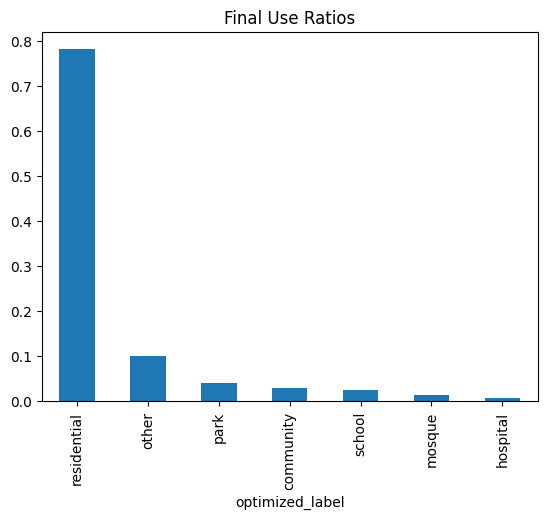

In [ ]:
#@title 6. Setup and Run Genetic Algorithm Urban Layout Optimization

import pygad
import numpy as np

def create_population_constrained(building_count, target_counts, use_map):
    genes = []
    for use, n in target_counts.items():
        code = use_map[use]
        genes += [code] * int(n)
    remainder = building_count - len(genes)
    genes += [use_map['residential']] * remainder
    np.random.shuffle(genes)
    return np.array(genes)

initial_population = np.array([
    create_population_constrained(len(buildings), target_counts, use_map)
    for _ in range(15)
])

ga_instance = pygad.GA(
    num_generations=30,
    num_parents_mating=7,
    fitness_func=fitness_func,
    sol_per_pop=15,
    num_genes=len(buildings),
    gene_space=list(use_map.values()),
    initial_population=initial_population,
    parent_selection_type="sss",
    keep_parents=3,
    mutation_percent_genes=10,
    suppress_warnings=True,
    stop_criteria=["reach_0.99"]
)

import time
start = time.time()
ga_instance.run()
end = time.time()
print(f"Optimization took {end - start:.2f} seconds.")

solution, solution_fitness, _ = ga_instance.best_solution()
buildings['optimized_use'] = solution.astype(int)
buildings['optimized_label'] = buildings['optimized_use'].map(reverse_use_map)
print("Final land use breakdown after optimization:")
print(buildings['optimized_label'].value_counts())

buildings['optimized_label'].value_counts(normalize=True).plot(kind='bar', title='Final Use Ratios')
plt.show()

In [ ]:
#@title 7. Optimized Typology Assignment (with War Deaths/Missing Correction, Dynamic Census Data)

import numpy as np
import pandas as pd

# --- 1. Load Gaza population and average household size from Census ---
def get_gaza_population_and_household_size():
    # Try Census1
    try:
        df1 = pd.read_excel('/content/drive/MyDrive/final/Census1.xlsx')
        pop_row = df1[df1.iloc[:,0].str.contains('Gaza', case=False, na=False)]
        pop_val = int(pop_row.iloc[0,1]) if not pop_row.empty else None
        hh_row = df1[df1.iloc[:,0].str.contains('household', case=False, na=False)]
        hh_size = float(hh_row.iloc[0,1]) if not hh_row.empty else None
        if pop_val and hh_size:
            return pop_val, hh_size
    except Exception as e:
        pass
    # Try Census2
    try:
        df2 = pd.read_excel('/content/drive/MyDrive/final/Census2.xlsx')
        pop_row = df2[df2.iloc[:,0].str.contains('Gaza', case=False, na=False)]
        pop_val = int(pop_row.iloc[0,1]) if not pop_row.empty else None
        hh_row = df2[df2.iloc[:,0].str.contains('household', case=False, na=False)]
        hh_size = float(hh_row.iloc[0,1]) if not hh_row.empty else None
        if pop_val and hh_size:
            return pop_val, hh_size
    except Exception as e:
        pass
    print("WARNING: Could not dynamically load census data, using defaults.")
    return 2106745, 5.7

gaza_population, avg_household_size = get_gaza_population_and_household_size()

# --- 2. Subtract war deaths and missing persons ---
war_deaths = 58026
missing = 11200
# Option 1: Conservative (subtract both deaths and all missing)
adjusted_population = gaza_population - war_deaths - missing
# Option 2: Only subtract deaths (if you expect many missing to return)
# adjusted_population = gaza_population - war_deaths

if adjusted_population < 0:
    print("Warning: Adjusted population negative; check input values.")
units_needed = int(np.ceil(adjusted_population / avg_household_size))
print(f"Original Gaza population: {gaza_population}, Average household size: {avg_household_size}")
print(f"After war adjustment: {adjusted_population} people, Needed units: {units_needed}")

# --- 3. Typology logic as before ---
typology_order = ['apartment_highrise', 'apartment_midrise', 'duplex', 'family_home']
typology_specs = {
    'apartment_highrise': {'units_per_bldg': 18, 'min_levels': 7},
    'apartment_midrise':  {'units_per_bldg': 8,  'min_levels': 3},
    'duplex':             {'units_per_bldg': 2,  'min_levels': 2},
    'family_home':        {'units_per_bldg': 1,  'min_levels': 1}
}
target_ratios = {
    'apartment_midrise': 0.62,
    'family_home': 0.25,
    'apartment_highrise': 0.10,
    'duplex': 0.03
}

res_mask = buildings['optimized_label'] == 'residential'
res_bldgs = buildings[res_mask].copy()
n_res = len(res_bldgs)

np.random.seed(42)
assign_counts = {typ: int(round(target_ratios[typ]*n_res)) for typ in target_ratios}
assign_counts['apartment_midrise'] += n_res - sum(assign_counts.values())
typology_list = (
    ['apartment_midrise'] * assign_counts['apartment_midrise'] +
    ['family_home']      * assign_counts['family_home'] +
    ['apartment_highrise'] * assign_counts['apartment_highrise'] +
    ['duplex'] * assign_counts['duplex']
)
np.random.shuffle(typology_list)
res_bldgs['res_typology'] = typology_list
res_bldgs['levels'] = res_bldgs['res_typology'].map({k: v['min_levels'] for k, v in typology_specs.items()})
res_bldgs['units']  = res_bldgs['res_typology'].map({k: v['units_per_bldg'] for k, v in typology_specs.items()})

current_units = res_bldgs['units'].sum()
deficit = units_needed - current_units

if deficit > 0:
    for low, up in [('family_home','duplex'), ('duplex','apartment_midrise'), ('apartment_midrise','apartment_highrise')]:
        upgradable = res_bldgs[res_bldgs['res_typology'] == low]
        for idx in upgradable.index:
            if deficit <= 0:
                break
            next_typ = up
            next_units = typology_specs[next_typ]['units_per_bldg']
            res_bldgs.at[idx, 'res_typology'] = next_typ
            res_bldgs.at[idx, 'levels'] = typology_specs[next_typ]['min_levels']
            res_bldgs.at[idx, 'units'] = next_units
            deficit -= (next_units - typology_specs[low]['units_per_bldg'])
        if deficit <= 0:
            break

final_units = res_bldgs['units'].sum()
print(f"Final residential units assigned: {final_units} (Needed: {units_needed})")
print("Final typology counts:", res_bldgs['res_typology'].value_counts())

buildings.loc[res_bldgs.index, 'res_typology'] = res_bldgs['res_typology']
buildings.loc[res_bldgs.index, 'levels'] = res_bldgs['levels']
buildings.loc[res_bldgs.index, 'units'] = res_bldgs['units']

print(buildings[buildings['optimized_label']=='residential'][['id','res_typology','levels','units']].head(10))


Original Gaza population: 2106745, Average household size: 5.1
After war adjustment: 2037519 people, Needed units: 399514
Final residential units assigned: 833130 (Needed: 399514)
Final typology counts: res_typology
apartment_midrise     73061
family_home           29460
apartment_highrise    11784
duplex                 3535
Name: count, dtype: int64
           id       res_typology  levels  units
0    41312981        family_home     1.0    1.0
1    41314445  apartment_midrise     3.0    8.0
2    41314593  apartment_midrise     3.0    8.0
3    41315311  apartment_midrise     3.0    8.0
4   295837446  apartment_midrise     3.0    8.0
6   295910243  apartment_midrise     3.0    8.0
7   295910245        family_home     1.0    1.0
8   295910247        family_home     1.0    1.0
9   295910252  apartment_midrise     3.0    8.0
10  295910255  apartment_midrise     3.0    8.0


# Section 5. Cost Prediction and  Rendering for current setup
Data set represent all structures that are standing, restorable, or part of the optimal recovery map.

In [ ]:
#@title 1. Gaza Material Take-Off and Cost Calculation (Post-2023 Inflation & Blockade, IBC/BIM Benchmarks)
import pandas as pd
import numpy as np

# 1. Load 2025 forecasted base material costs (USD/ton)
costs_df = pd.read_csv('/content/drive/MyDrive/final/forecasted_costs_2025.csv')
costs_df.columns = [c.strip().lower().replace(' ', '_') for c in costs_df.columns]

# 2. OFFICIAL INFLATION AND BLOCKADE MARKUPS (sources: UN OCHA, World Bank, Gisha, etc.)
# Cement: 19× (OCHA), Steel: 7× (historical Gisha & market survey), Gravel/Sand/Stone: 2.5× (avg. Gisha + current market)
gaza_price_multiplier = {
    'cement': 19.0,     # OCHA, Oct 2024: 1900% price increase
    'steel': 7.0,       # Gisha, typical smuggling/blockade markup
    'sand': 2.5,        # Gisha/UN, severe scarcity markup
    'stone': 2.5,       # as above
    'gravel': 2.5
}
# Optionally, you could use slightly lower markups if you want a minimum scenario. But 19x cement is the "real" number for now.

def get_gaza_material_price(material):
    row = costs_df[costs_df['component'] == material]
    base = row['predicted_2025_cost'].values[0] if not row.empty else 0
    base = float(base)
    markup = gaza_price_multiplier.get(material, 1.0)
    return base * markup

# 3. BIM/IBC Quantities (ton per m² gross floor area)
material_benchmarks_per_m2 = {
    'cement': 0.38,
    'steel': 0.09,
    'sand': 0.60,
    'stone': 0.18,
    'gravel': 0.23
}
gfa_per_typology = {
    'family_home': 160,
    'duplex': 220,
    'apartment_midrise': 480,
    'apartment_highrise': 1200
}
# Non-residential average gross floor areas (best-practice/UNRWA examples)
gfa_per_nres = {
    'school': 2500,
    'hospital': 8000,
    'community': 1200,
    'mosque': 450,
    'park': 0,   # parks: no structure
    'other': 600
}

# 4. Calculate per-building takeoff and material cost
for mat in material_benchmarks_per_m2.keys():
    buildings[mat + '_tons'] = 0.0
    buildings[mat + '_usd'] = 0.0

res_mask = buildings['optimized_label'] == 'residential'
for typ, gfa in gfa_per_typology.items():
    mask = res_mask & (buildings['res_typology'] == typ)
    for mat in material_benchmarks_per_m2:
        tons = gfa * material_benchmarks_per_m2[mat]
        price = get_gaza_material_price(mat)
        buildings.loc[mask, mat + '_tons'] = tons
        buildings.loc[mask, mat + '_usd'] = tons * price

for use, gfa in gfa_per_nres.items():
    mask = buildings['optimized_label'] == use
    for mat in material_benchmarks_per_m2:
        tons = gfa * material_benchmarks_per_m2[mat] if gfa else 0
        price = get_gaza_material_price(mat)
        buildings.loc[mask, mat + '_tons'] = tons
        buildings.loc[mask, mat + '_usd'] = tons * price

# 5. Print and aggregate
mat_costs = [mat+'_usd' for mat in material_benchmarks_per_m2]
print("Per-building sample:", buildings[['optimized_label','res_typology','levels','units'] + mat_costs].head(10))
print("TOTAL material cost (USD) by type:")
for mat in material_benchmarks_per_m2:
    total_usd = buildings[mat+'_usd'].sum()
    print(f"  {mat:8}: ${total_usd:,.0f}")

total_material_cost = sum(buildings[mat+'_usd'].sum() for mat in material_benchmarks_per_m2)
print(f"\nTOTAL MATERIAL COST (ALL STRUCTURES, BLOCKADE-INFLATED): ${total_material_cost:,.0f} USD")


Per-building sample:   optimized_label       res_typology  levels  units    cement_usd  \
0     residential        family_home     1.0    1.0  8.670381e+04   
1     residential  apartment_midrise     3.0    8.0  2.601114e+05   
2     residential  apartment_midrise     3.0    8.0  2.601114e+05   
3     residential  apartment_midrise     3.0    8.0  2.601114e+05   
4     residential  apartment_midrise     3.0    8.0  2.601114e+05   
5          school                NaN     NaN    NaN  1.354747e+06   
6     residential  apartment_midrise     3.0    8.0  2.601114e+05   
7     residential        family_home     1.0    1.0  8.670381e+04   
8     residential        family_home     1.0    1.0  8.670381e+04   
9     residential  apartment_midrise     3.0    8.0  2.601114e+05   

      steel_usd       sand_usd     stone_usd    gravel_usd  
0  1.109617e+05    8406.186254   4034.969402   1933.422838  
1  3.328850e+05   25218.558761  12104.908205   5800.268515  
2  3.328850e+05   25218.558761  1210

In [ ]:
#@title 2. Add Labor and Logistics for Full Reconstruction Cost (Gaza Post-Blockade, Post-2023)

# World Bank, UN, and local engineering benchmarks often place Gaza labor and logistics at 40-60% of material cost under blockade due to delay, scarcity, and informal fees (see OCHA, Gisha, World Bank economic monitor, UNRWA project budgets).
labor_multiplier = 0.48  # 48% of material cost (mid-range estimate)
logistics_multiplier = 0.22  # 22% of material cost

labor_cost = total_material_cost * labor_multiplier
logistics_cost = total_material_cost * logistics_multiplier
final_total_cost = total_material_cost + labor_cost + logistics_cost

print(f"Estimated total labor cost:     ${labor_cost:,.0f}")
print(f"Estimated total logistics cost: ${logistics_cost:,.0f}")
print(f"\nTOTAL RECONSTRUCTION COST (Materials + Labor + Logistics): ${final_total_cost:,.0f} USD")


Estimated total labor cost:     $56,767,793,095
Estimated total logistics cost: $26,018,571,835

TOTAL RECONSTRUCTION COST (Materials + Labor + Logistics): $201,052,600,545 USD


In [ ]:
#@title 3. Export Full Gaza Dataset for ArcGIS with All Cost and Typology Data

import geopandas as gpd

gdf = gpd.GeoDataFrame(buildings, geometry='geometry', crs='EPSG:32636')
gdf = gdf.to_crs('EPSG:4326')

cols_to_keep = [
    'id', 'optimized_label', 'res_typology', 'levels', 'units', 'zone',
    'cement_usd','steel_usd','sand_usd','stone_usd','gravel_usd',
    'cement_tons','steel_tons','sand_tons','stone_tons','gravel_tons',
    'geometry'
]
cols_to_keep = [c for c in cols_to_keep if c in gdf.columns]
gdf_out = gdf[cols_to_keep].copy()

output_geojson = "/content/drive/MyDrive/final/optimized_gaza_reconstruction.geojson"
gdf_out.to_file(output_geojson, driver="GeoJSON")
print(f"Exported to {output_geojson} ({len(gdf_out)} buildings)")


Exported to /content/drive/MyDrive/final/optimized_gaza_reconstruction.geojson (150687 buildings)


# Section 6. Citi Expansion Post Recovery
Simulating new infill and expansion, while respecting open space and road networks (from OSM), and creating a unified, costed, GIS-ready dataset.

In [ ]:
import geopandas as gpd
from shapely.geometry import box

#@title 1. Define Gaza bounding box (WGS84)
gaza_bbox = (34.194722, 31.22, 34.574722, 31.566667)  # (minx, miny, maxx, maxy)
gaza_poly = gpd.GeoDataFrame({'geometry':[box(*gaza_bbox)]}, crs="EPSG:4326")

lines_gdf = gpd.read_file('/content/drive/MyDrive/final/palestine_israel_lines.geojson').to_crs(4326)
parks_gdf = gpd.read_file('/content/drive/MyDrive/final/palestine_israel_parks.geojson').to_crs(4326)

lines_gdf_clip = gpd.overlay(lines_gdf, gaza_poly, how='intersection')
parks_gdf_clip = gpd.overlay(parks_gdf, gaza_poly, how='intersection')

print(f"Clipped lines: {len(lines_gdf_clip)} | Clipped parks: {len(parks_gdf_clip)}")

Clipped lines: 26472 | Clipped parks: 408


In [ ]:
#@title 2. Filter clipped lines for relevant infrastructure
roads_gdf   = lines_gdf_clip[lines_gdf_clip['highway'].notnull()]
rivers_gdf  = lines_gdf_clip[lines_gdf_clip['waterway'].isin(['river', 'stream', 'canal', 'drain'])]
routes_gdf  = lines_gdf_clip['railway'].notnull() if 'railway' in lines_gdf_clip.columns else gpd.GeoDataFrame(columns=lines_gdf_clip.columns)
routes_gdf  = lines_gdf_clip[lines_gdf_clip['railway'].notnull()] if 'railway' in lines_gdf_clip.columns else gpd.GeoDataFrame(columns=lines_gdf_clip.columns)

print(f"Roads: {len(roads_gdf)} | Rivers: {len(rivers_gdf)} | Routes: {len(routes_gdf)}")

Roads: 24909 | Rivers: 123 | Routes: 0


In [ ]:
#@title 3. Project features that are not empty
roads_gdf   = roads_gdf.to_crs(32636)
rivers_gdf  = rivers_gdf.to_crs(32636)
parks_gdf_clip = parks_gdf_clip.to_crs(32636)

if not routes_gdf.empty:
    routes_gdf = routes_gdf.to_crs(32636)
    route_buffer = routes_gdf.buffer(8)
else:
    route_buffer = []

# Buffer the others
road_buffer   = roads_gdf.buffer(8)     # 8 meters for roads
river_buffer  = rivers_gdf.buffer(15)   # 15 meters for rivers/streams/canals
park_polys    = parks_gdf_clip.geometry # Polygons, no buffer needed

print("Buffered all exclusion features.")

Buffered all exclusion features.


In [ ]:
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from shapely.ops import unary_union

all_geoms = list(road_buffer) + list(river_buffer) + list(park_polys)
if 'route_buffer' in locals() and len(route_buffer) > 0:
    all_geoms += list(route_buffer)

no_build_union = unary_union(all_geoms)

# If you have a precise Gaza boundary (GeoDataFrame), use it. Otherwise use bounding box:
gaza_boundary = gpd.GeoDataFrame(geometry=[no_build_union.convex_hull], crs="EPSG:32636")

# Define grid spacing (in meters)
cell_size = 30  # About size of a midrise building

# Build the bounding box for grid generation
xmin, ymin, xmax, ymax = gaza_boundary.total_bounds
x_coords = np.arange(xmin, xmax, cell_size)
y_coords = np.arange(ymin, ymax, cell_size)

candidate_points = []
for x in x_coords:
    for y in y_coords:
        pt = Point(x, y)
        if gaza_boundary.geometry.iloc[0].contains(pt) and not no_build_union.contains(pt):
            candidate_points.append(pt)

# Convert to GeoDataFrame
infill_gdf = gpd.GeoDataFrame({'geometry': candidate_points}, crs="EPSG:32636")
print(f"Generated {len(infill_gdf)} grid-based candidate infill locations (outside all no-build zones).")

# (Optional) Downsample if you want only a fraction of possible infill sites (e.g. for 20% population growth scenario)
desired_new = int(0.20 * len(candidate_points))
if len(infill_gdf) > desired_new:
    infill_gdf = infill_gdf.sample(desired_new, random_state=42).reset_index(drop=True)

infill_gdf['id'] = ['new_' + str(i) for i in range(len(infill_gdf))]

Generated 965355 grid-based candidate infill locations (outside all no-build zones).


In [ ]:
#@title 4. Sample Polygons by Use Type for New Expansion Sites
import geopandas as gpd
import numpy as np
import pandas as pd

# 1. Load your existing optimized buildings (with polygons and use)
buildings = gpd.read_file("/content/drive/MyDrive/final/optimized_gaza_reconstruction.geojson")
buildings = buildings[~buildings.geometry.is_empty & buildings.geometry.notnull()]

# 2. Define optimal land use ratios for expansion
optimal_ratios = {
    'residential': 0.78,
    'school': 0.025,
    'park': 0.04,
    'mosque': 0.015,
    'hospital': 0.008,
    'community': 0.03,
    'other': 0.10
}

# 3. Number of new buildings for expansion
expansion_fraction = 0.20
n_existing = len(buildings)
n_expansion = int(expansion_fraction * n_existing)

# 4. Calculate how many of each use type are needed
expansion_counts = {use: int(np.round(ratio * n_expansion)) for use, ratio in optimal_ratios.items()}
# Fill rounding error with residential
expansion_counts['residential'] += n_expansion - sum(expansion_counts.values())

# 5. Sample polygons by use type
new_expansion_polys = []
new_expansion_labels = []

for use, count in expansion_counts.items():
    source_polys = buildings[buildings['optimized_label'] == use]
    if source_polys.empty:
        print(f"Warning: No existing polygons for use {use}—skipping.")
        continue
    samples = source_polys.sample(count, replace=True, random_state=42)
    # Jitter polygons for uniqueness
    samples = samples.copy()
    samples['geometry'] = samples['geometry'].apply(lambda g: shapely.affinity.translate(
        g, xoff=np.random.uniform(-50, 50), yoff=np.random.uniform(-50, 50)))
    new_expansion_polys.append(samples['geometry'])
    new_expansion_labels.extend([use]*len(samples))

# 6. Combine all into a new GeoDataFrame
from itertools import chain
expansion_geoms = list(chain.from_iterable([geoms.tolist() for geoms in new_expansion_polys]))
expansion_labels = new_expansion_labels

expansion_gdf = gpd.GeoDataFrame({
    'id': [f"exp_{i}" for i in range(len(expansion_geoms))],
    'optimized_label': expansion_labels,
    'geometry': expansion_geoms
}, crs=buildings.crs)

print(expansion_gdf['optimized_label'].value_counts())
print(f"Total new expansion polygons: {len(expansion_gdf)}")

optimized_label
residential    23568
other           3014
park            1205
community        904
school           753
mosque           452
hospital         241
Name: count, dtype: int64
Total new expansion polygons: 30137


In [ ]:
#@title 5. Assign Typologies, Units and Levels
# Typology assignment for new residential expansion
typology_specs = {
    'apartment_highrise': {'units': 18, 'levels': 7, 'gfa': 1200},
    'apartment_midrise':  {'units': 8,  'levels': 3, 'gfa': 480},
    'duplex':             {'units': 2,  'levels': 2, 'gfa': 220},
    'family_home':        {'units': 1,  'levels': 1, 'gfa': 160}
}
exp_typology_ratios = {
    'apartment_midrise': 0.6,
    'apartment_highrise': 0.15,
    'family_home': 0.2,
    'duplex': 0.05
}

res_mask = expansion_gdf['optimized_label'] == 'residential'
n_res = res_mask.sum()
res_typologies = (
    ['apartment_midrise'] * int(exp_typology_ratios['apartment_midrise'] * n_res) +
    ['apartment_highrise'] * int(exp_typology_ratios['apartment_highrise'] * n_res) +
    ['family_home'] * int(exp_typology_ratios['family_home'] * n_res) +
    ['duplex'] * (n_res - (int(exp_typology_ratios['apartment_midrise'] * n_res) +
                           int(exp_typology_ratios['apartment_highrise'] * n_res) +
                           int(exp_typology_ratios['family_home'] * n_res)))
)
np.random.shuffle(res_typologies)
expansion_gdf.loc[res_mask, 'res_typology'] = res_typologies

for attr in ['units', 'levels', 'gfa']:
    expansion_gdf.loc[res_mask, attr] = expansion_gdf.loc[res_mask, 'res_typology'].map({k: v[attr] for k, v in typology_specs.items()})

# Non-residential GFA/levels (adjust as needed)
use_area_defaults = {
    'school': 2500, 'hospital': 8000, 'community': 1200, 'mosque': 450, 'park': 0, 'other': 600
}
expansion_gdf['gfa'] = expansion_gdf.apply(
    lambda row: row['gfa'] if row['optimized_label'] == 'residential' else use_area_defaults.get(row['optimized_label'], 600), axis=1
)
expansion_gdf['levels'] = expansion_gdf.apply(
    lambda row: row['levels'] if row['optimized_label'] == 'residential' else 1, axis=1
)

In [ ]:
#@title 6. Calculate Materials and Costs for All Uses
material_benchmarks_per_m2 = {
    'cement': 0.38, 'steel': 0.09, 'sand': 0.60, 'stone': 0.18, 'gravel': 0.23
}
gaza_price_multiplier = {'cement': 19.0, 'steel': 7.0, 'sand': 2.5, 'stone': 2.5, 'gravel': 2.5}
costs_df = pd.read_csv('/content/drive/MyDrive/final/forecasted_costs_2025.csv')
costs_df.columns = [c.strip().lower().replace(' ', '_') for c in costs_df.columns]
def get_gaza_material_price(material):
    row = costs_df[costs_df['component'] == material]
    base = float(row['predicted_2025_cost'].values[0]) if not row.empty else 0
    markup = gaza_price_multiplier.get(material, 1.0)
    return base * markup

for mat in material_benchmarks_per_m2:
    expansion_gdf[mat+'_tons'] = expansion_gdf['gfa'] * material_benchmarks_per_m2[mat]
    expansion_gdf[mat+'_usd'] = expansion_gdf[mat+'_tons'] * get_gaza_material_price(mat)

In [ ]:
#@title 7. Merge with Existing City for Final GIS Output
# Load your original optimized city buildings
existing_gdf = gpd.read_file("/content/drive/MyDrive/final/optimized_gaza_reconstruction.geojson")
existing_gdf = existing_gdf[~existing_gdf.geometry.is_empty & existing_gdf.geometry.notnull()]

# Ensure columns match (add missing columns to either DataFrame)
for col in expansion_gdf.columns:
    if col not in existing_gdf.columns:
        existing_gdf[col] = np.nan
for col in existing_gdf.columns:
    if col not in expansion_gdf.columns:
        expansion_gdf[col] = np.nan

# Concatenate for final full city + expansion scenario
future_gaza = pd.concat([existing_gdf, expansion_gdf], ignore_index=True)
future_gaza = gpd.GeoDataFrame(future_gaza, geometry='geometry', crs=existing_gdf.crs)
future_gaza = future_gaza.to_crs(4326)

# Export as GeoJSON or GPKG for ArcGIS/QGIS
future_gaza.to_file("/content/drive/MyDrive/final/future_gaza_expanded_optimized.geojson", driver="GeoJSON")
print("Exported future Gaza (optimized + expansion) to GeoJSON.")

Exported future Gaza (optimized + expansion) to GeoJSON.


In [ ]:
#@title 8. Total Costs Calculations
# List of all material USD columns (update if you use more materials)
material_cost_cols = [col for col in future_gaza.columns if col.endswith('_usd')]
total_material_cost = future_gaza[material_cost_cols].sum().sum()
print(f"TOTAL MATERIAL COST (USD): ${total_material_cost:,.0f}")

# Gaza-typical logistics/labor multipliers
labor_multiplier = 0.48     # 48% of material cost (UN/World Bank, for blockade conditions)
logistics_multiplier = 0.22 # 22% of material cost

total_labor_cost = total_material_cost * labor_multiplier
total_logistics_cost = total_material_cost * logistics_multiplier
total_combined_cost = total_material_cost + total_labor_cost + total_logistics_cost

print(f"TOTAL COST (Materials + Labor + Logistics): ${total_combined_cost:,.0f}")


TOTAL MATERIAL COST (USD): $143,379,701,800
TOTAL COST (Materials + Labor + Logistics): $243,745,493,060


# Section 7. Visualization

/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 300143466 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(
/tmp/ipython-input-11-858797291.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  damage_cmap = plt.cm.get_cmap('Reds_r', 3)
/tmp/ipython-input-11-858797291.py:125: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf['use_label']==lbl].plot(ax=axs[i], color=color, edgecolor='k', linewidth=0.2, alpha=0.85, label=lbl)
/tmp/ipython-input-11-858797291.py:125: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf['use_label']==lbl].plot(ax=axs[i], color=color, edgecolor='k', linewidt

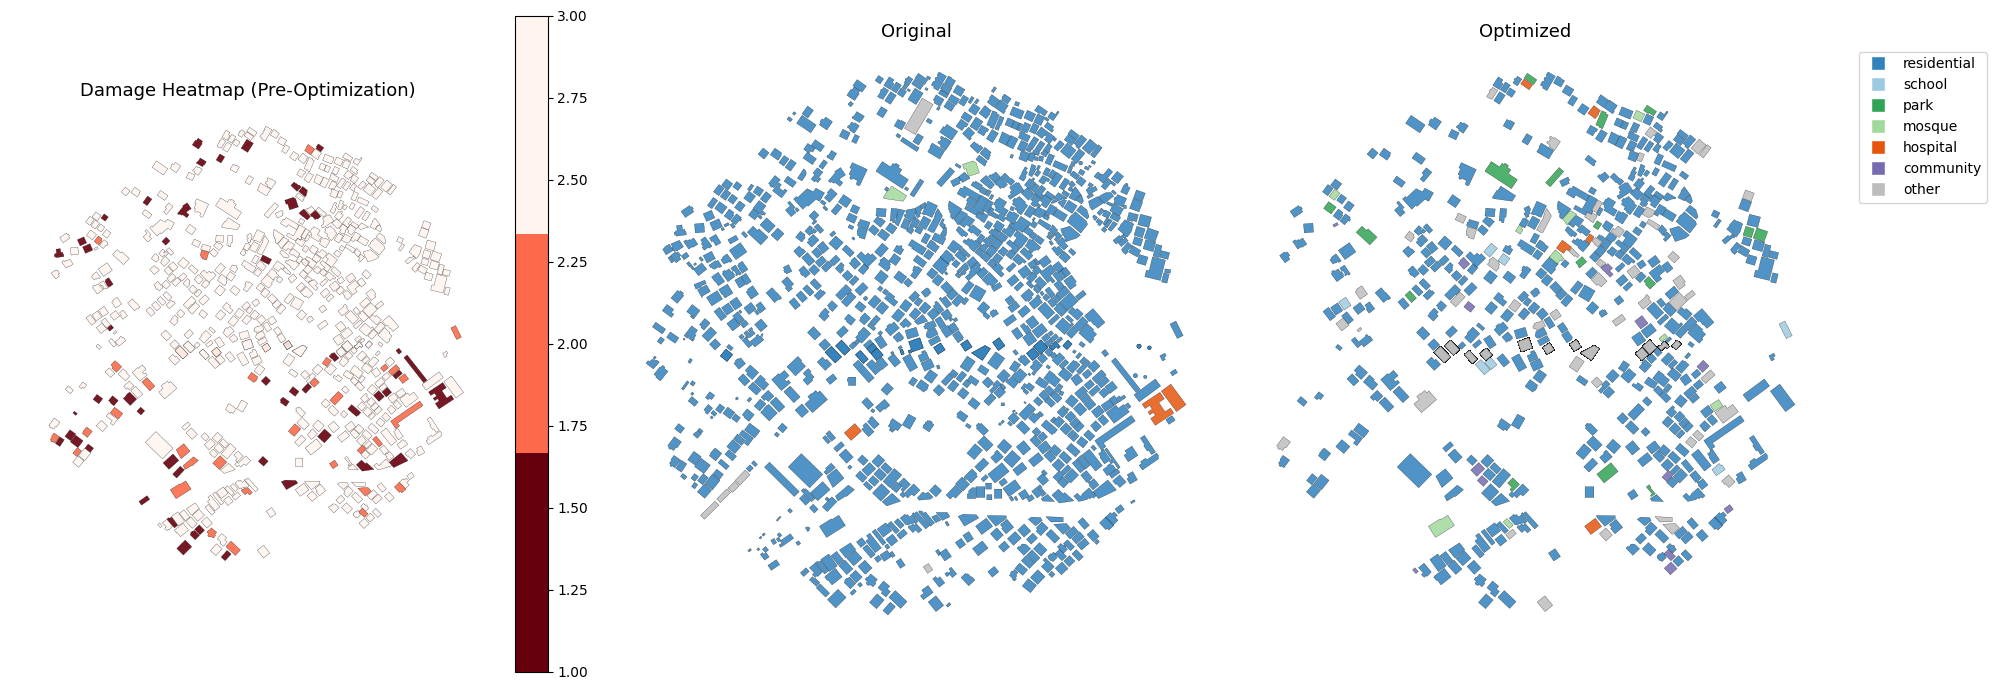


--- Urban Area Neighborhood (radius 400m) ---
Original: use_label
residential    1025
other             6
hospital          3
mosque            2
Name: count, dtype: int64
Optimized: use_label
residential    5013
other           619
park            256
community       204
school          148
mosque           99
hospital         53
Name: count, dtype: int64
Damage levels: model_pred_label
1     55
2     35
3    492
Name: count, dtype: int64


In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

# --- Load datasets (assume drive already mounted) ---
original = gpd.read_file('/content/drive/MyDrive/damage_features_buildings_updated.gpkg')
optimized = gpd.read_file('/content/drive/MyDrive/final/optimized_gaza_reconstruction.geojson')
expanded  = gpd.read_file('/content/drive/MyDrive/final/future_gaza_expanded_optimized.geojson')
predicted = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions.gpkg')

# --- Unified use mapping as before ---
use_map = {
    'residential': 0, 'house': 0, 'apartments': 0, 'detached': 0, 'yes': 0,
    'public': 5, 'community': 5,
    'school': 1, 'college': 1, 'university': 1, 'kindergarten': 1,
    'mosque': 3, 'religious': 3, 'church': 3,
    'hospital': 4,
    'warehouse': 6, 'industrial': 6, 'commercial': 6, 'retail': 6, 'office': 6, 'hotel': 6, 'sports_centre': 6,
    'supermarket': 6, 'farm': 6, 'farm_auxiliary': 6, 'bakehouse': 6, 'garage': 6, 'service': 6,
    'hangar': 6, 'shed': 6, 'roof': 6, 'stable': 6, 'cowshed': 6, 'greengrocer': 6, 'hut': 6,
    'tank': 6, 'bunker': 6, 'water_tower': 6, 'greenhouse': 6, 'greenhouse_horticulture': 6,
    'ruins': 6, 'destroyed': 6, 'grandstand': 6, 'park': 2, 'other': 6
}
label_map = {
    0: "residential", 1: "school", 2: "park", 3: "mosque",
    4: "hospital", 5: "community", 6: "other"
}
def classify_use_final(raw_value):
    if pd.isnull(raw_value): return use_map['other']
    v = str(raw_value).strip().lower()
    if v in use_map: return use_map[v]
    if any(w in v for w in ['school', 'college', 'university', 'kindergarten']):
        return use_map['school']
    if any(w in v for w in ['mosque', 'church', 'religious']):
        return use_map['mosque']
    if 'hospital' in v: return use_map['hospital']
    if any(w in v for w in ['house', 'apartment', 'residential', 'detached']):
        return use_map['residential']
    if 'park' in v: return use_map['park']
    if any(w in v for w in ['public', 'community']):
        return use_map['community']
    return use_map['other']
def label_to_code(lbl):
    rev_map = {v: k for k, v in label_map.items()}
    return rev_map.get(lbl, 6)
original['use_code'] = original['building'].astype(str).apply(classify_use_final)
original['use_label'] = original['use_code'].map(label_map)
optimized['use_code'] = optimized['optimized_label'].map(label_to_code)
optimized['use_label'] = optimized['use_code'].map(label_map)
expanded['use_code'] = expanded['optimized_label'].map(label_to_code)
expanded['use_label'] = expanded['use_code'].map(label_map)

# --- CRS for distance in meters ---
crs_proj = 32636
original = original.to_crs(crs_proj)
optimized = optimized.to_crs(crs_proj)
expanded  = expanded.to_crs(crs_proj)
predicted = predicted.to_crs(crs_proj)

# --- Make sure all have 'centroid' column ---
for gdf in [original, optimized, expanded, predicted]:
    if 'centroid' not in gdf.columns:
        gdf['centroid'] = gdf.geometry.centroid

# --- For all: calculate centroids for fast search ---
original['centroid'] = original.geometry.centroid
optimized['centroid'] = optimized.geometry.centroid
expanded['centroid'] = expanded.geometry.centroid

# --- 1. RANDOM EXISTING NEIGHBORHOOD (use optimized to pick center) ---
np.random.seed(42)
center_idx = np.random.choice(optimized.index)
center_pt1 = optimized.loc[center_idx, 'centroid']
radius = 400

def buildings_within_radius(gdf, center, radius):
    gdf = gdf.copy()
    gdf['dist_to_center'] = gdf['centroid'].distance(center)
    return gdf[gdf['dist_to_center'] <= radius].copy()

hood_original  = buildings_within_radius(original, center_pt1, radius)
hood_optimized = buildings_within_radius(optimized, center_pt1, radius)
hood_pred      = buildings_within_radius(predicted, center_pt1, radius)

# --- 2. PURE EXPANSION NEIGHBORHOOD (no optimized buildings within radius) ---
optimized_ids = set(optimized['id'].astype(str))
expanded['is_new_expansion'] = ~expanded['id'].astype(str).isin(optimized_ids)
expansion_only = expanded[expanded['is_new_expansion']].copy()

exp_xy = np.array(list(expansion_only['centroid'].apply(lambda g: (g.x, g.y))))
tree_opt = cKDTree(np.array(list(optimized['centroid'].apply(lambda g: (g.x, g.y)))))

found_exp = False
for idx, row in expansion_only.iterrows():
    cpt = row['centroid']
    idxs = tree_opt.query_ball_point([cpt.x, cpt.y], radius)
    if len(idxs) == 0:
        center_pt2 = cpt
        found_exp = True
        break
if not found_exp:
    raise ValueError("No purely expansion-driven neighborhood found.")

hood_expanded2 = buildings_within_radius(expanded, center_pt2, radius)
hood_pred2     = buildings_within_radius(predicted, center_pt2, radius)

# --- Consistent use colors ---
use_colors = {
    "residential": "#3182bd",  "school": "#9ecae1",   "park": "#31a354",
    "mosque": "#a1d99b",       "hospital": "#e6550d", "community": "#756bb1",
    "other": "#bdbdbd"
}
damage_col = 'model_pred_label'
damage_cmap = plt.cm.get_cmap('Reds_r', 3)

# --- IMAGE 1: Damage/Old/Optimized for the SAME URBAN AREA ---
fig, axs = plt.subplots(1, 3, figsize=(20, 7), sharex=True, sharey=True)
hood_pred.plot(ax=axs[0], column=damage_col, cmap=damage_cmap, legend=True, edgecolor='k', linewidth=0.2, alpha=0.9)
axs[0].set_title("Damage Heatmap (Pre-Optimization)", fontsize=13)
axs[0].set_axis_off()
for gdf, title, i in zip([hood_original, hood_optimized], ["Original", "Optimized"], [1, 2]):
    for lbl, color in use_colors.items():
        gdf[gdf['use_label']==lbl].plot(ax=axs[i], color=color, edgecolor='k', linewidth=0.2, alpha=0.85, label=lbl)
    axs[i].set_title(title, fontsize=13)
    axs[i].set_axis_off()
handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=use_colors[u], markersize=10, label=u) for u in use_colors]
axs[2].legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"\n--- Urban Area Neighborhood (radius {radius}m) ---")
print("Original:", hood_original['use_label'].value_counts())
print("Optimized:", hood_optimized['use_label'].value_counts())
print("Damage levels:", hood_pred[damage_col].value_counts().sort_index())
